In [1]:
import pandas as pd
import math

In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style='darkgrid') # darkgrid

plt.rc('figure', figsize=(10, 6.25)) # 10, 6.5
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "Times New Roman"

fontsize = 15

# "raw" data

every tag value is one row

In [4]:
# load from excel
raw = pd.read_excel("research_seminar.mx22.xlsx" ,sheet_name="Codierte Segmente")
# drop anything that is not a real paper entry (drop the metadata files from maxqda)
raw = raw[(raw["Dokumentgruppe"] == 'Paper_Keywordsearch') | (raw["Dokumentgruppe"] == 'Paper_Backwardsearch') | (raw["Dokumentgruppe"] == 'Paper_Zugriff')]
# drop silly variables
raw = raw.drop(axis=1, labels = ['Gewicht', 'Erstellt von','Erstellt am', 'Dokumentgruppe', 'Fläche', 'Abdeckungsgrad %', 'Anfang', 'Ende', 'Farbe'])
# create usefull index
raw = raw.set_index("Dokumentname")

# data cleaning

In [5]:
#programming language
### lower_case all programming language entries, replace that one misspelled "c++"-entry
raw.loc[(raw['Code'] == 'language','Segment')] = raw.loc[(raw['Code'] == 'language','Segment')].str.lower().replace('c +', 'c++')
#dl framework
### lowercase, trim whitespace, fix spelling/formatting mistakes, replace torch with pytorch in that 1 paper, since it is clear from context they are using pytorch
raw.loc[(raw['Code'] == 'Framework','Segment')] = raw.loc[(raw['Code'] == 'Framework','Segment')].str.lower().str.strip(' ').str.replace('ten- \nsorflow', 'tensorflow',regex=False).str.replace('tensorfow', 'tensorflow',regex=False).str.replace('fast.ai', 'fastai',regex=False).str.replace('caf e', 'caffe',regex=False).str.replace(r'\btorch\b','pytorch',regex=True).str.replace(r'ten-sorflow','tensorflow',regex=True)
#models
# named models
### lower, strip whitespaces, strip linebreaks , strip "-", lots of manual mappings
result = raw.loc[(raw['Code'] == r'models\name','Segment')].str.lower().str.strip().str.replace(" \n", "").str.replace("-", "")
result = result.str.replace('vggnet','vgg').str.replace('vgg ','vgg').str.replace('inception v','inceptionv').str.replace('resnet ','resnet')
result = result.replace('maskrcnn','mask rcnn').replace('fasterrcnn','faster rcnn').replace('go glen t','googlenet')
result = result.replace('prn50','resnet50').replace('prn101','resnet101').replace('prn152','resnet152').replace('singleshot multibox detector','ssd')
result = result.replace('dcan: deep contouraware network','dcan').replace('yolo v3 (320x320)','yolov3').replace('vg face','vgg')
result = result.replace('vggf','vgg').replace('1.0 mobilenet224','mobilenet').replace('squeezeandexcitation networks (senets)','senet')
result = result.str.replace('se net ','senet').replace('ssd (300x300)','ssd').replace('50layer seresnext','seresnext50')
result = result.replace('vanilla unets [12] with a depth between 3 and 6','unet')
raw.loc[(raw['Code'] == r'models\name','Segment')] = result
# modified models
result2 = raw.loc[(raw['Code'] == r'models\modified version of (name)','Segment')].str.lower().str.strip().str.replace(" \n", "").str.replace("-", "")
result2 = result2.replace('dunet','unet').replace('unet+ (u.s.)','unet')
result2 = result2.replace('resnetlike architecture','resnet').replace('selected vgg16','vgg16').replace('resnet+svm','resnet')
result2 = result2.replace('modified mask rcnn','maskrcnn').replace('deformable unet','unet').replace('resnet+vat+svm','resnet')
result2 = result2.replace('unet+ (t.c.)','unet').replace('resnet+vat','resnet')
result2 = result2.replace('cycleconsistent adversarial network','cyclegan')
result2 = result2.replace('y. a resnet 18 [8] base network was extended','resnet18').replace('attentionyolo','yolo')
result2 = result2.replace('soyolo','yolo').replace('unet++','unet').replace('resnet50lstm','resnet50').replace('xceptionlstm','xception')
result2 = result2.replace('xceptionresnet50lstm','xceptionresnet50').replace('inceptionv3lstm','inceptionv3').replace('maskrcnn','mask rcnn')
raw.loc[(raw['Code'] == r'models\modified version of (name)','Segment')] = result2

In [6]:
## metrics
result = raw.loc[(raw['Code']==r'evaluation\metric','Segment')]

# broad formatting/cleaning
result = result.str.lower().str.replace("- \n", "").str.replace(" \n", "").str.strip()

# n to 1 replacements
f_alias = ['f-measure','f1-score','f1 score','f-score','f1','f1score','f1-measure','f − measure','fscore','f   score','weight f1 score','weighted f1 score','macro f1-score','weighted f1-score','weighted f-1 score','micro f1','macro f1','micro-f1','weightedf1']
result = result.replace(f_alias,'f score')
acc_alias = ['ܣccuracy','acc','ac uracy','average accuracy','mean accuracy','meanaccuracy','globalaccuracy','balanced accuracy','balancedaccuracy','total classification accuracy','acuracy']
result = result.replace(acc_alias,'accuracy')
map_alias = ['mean average precision','meanaverage precision (map)','mean ap(map)','mean average precision(map)','mean average precision (map)']
result = result.replace(map_alias,'map')
ap_alias = ['average precision (ap)','average precision','average precision(ap)','ap(0.5:0.95)','ap75','ap50']
result = result.replace(ap_alias,'ap')
specifcity_alias = ['specifcity','specifity','average specificity','specif icity']
result = result.replace(specifcity_alias,'specificity')
auroc_alias = ['auc-roc','area under the curve (auc) of the receiver operating characteristic (roc) curve','au roc']
result = result.replace(auroc_alias,'auroc')
recall_alias = ['weighted recall','recal']
result = result.replace(recall_alias,'recall')
dice_alias = ['dice score','dice','dicecoefficient']
result = result.replace(dice_alias,'dice coefficient')

# replacements with "contains-logic"
result.loc[result.str.contains('iou')] = 'iou'
result.loc[result.str.contains('bf')] = 'bf'
result[result.str.contains('misclassification error')] = 'misclassification error'
result[result.str.contains('error rate')] = 'misclassification error'
result[result.str.contains('hausdorff')] = 'hausdorff distance'
result[result.str.contains('ppv')] = 'ppv'
result[result.str.contains('kappa')] = 'kappa index'
result[result.str.contains('npv')] = 'npv'
result[result.str.contains('fnr')] = 'fnr'

# singular replacements
result = result.replace('average recall','AR')
result = result.replace('auc of theprecision–recall curve','auprc')
result = result.replace('truenegative rate','tnr')
result = result.replace('false negative rate','fnr')
result = result.replace('positive predictive value','ppv')
result = result.replace('intersection over union','iou')
result = result.replace('area under the curve','auc')
result = result.replace('p recision','precision').replace('presicion','precision')
result = result.replace('false positive rate (fpr)','fpr').replace('misdiagnosis rate','fpr')
result = result.replace('negative predictive value','npv')
result = result.replace('roc curve','roc')
result = result.replace('average sensitivity','sensitivity')
result = result.replace('p','precision').replace('true detection','true detection rate')
result = result.replace('����� (������������. ) =�����������','recall').replace('��������+��������','precision')
result = result.replace('Detection accuracy was measured using precision-recall','ap')
result = result.replace('true positive rate','tpr')


# synonyms
## jaccard index = iou
result.loc[result.str.contains('jaccard')] = 'jaccard'
result = result.replace('iou','jaccard')
## map and ap can be the exact same thing (depending on context). If not, map is just ap averaged over all classes
result = result.replace('map','ap') 
## tpr = recall = sensitivity
recall_alias = ['tpr','sensitivity']
result = result.replace(recall_alias,'recall')
## specificity = tnr
result = result.replace('tnr','specificity')
## precision = ppv
result = result.replace('ppv','precision')
## auroc = auc (auc is technically speaking not precise - could be the area under any curve but from context in the papers it is clear they mean auroc)
result = result.replace('auc','auroc')
## dice == fscore for segmentation
result = result.replace('dice coefficient','f score')
raw.loc[(raw['Code']==r'evaluation\metric','Segment')] = result

# format metric names
formatting = {'accuracy':'Accuracy',
'recall':'Recall',
'precision':'Precision',
'f score':'F-Score',
'specificity':'Specificity',
'ap':'Average\nPrecision',
'jaccard':'Jaccard',
'auroc':'AUROC',
#'dice coefficient':'Dice',
'roc':'ROC',
'fpr':'FPR',
'misclassification error':'ME',
'fnr':'FNR',
'kappa index':'Kappa',
'hausdorff distance':'Hausdorff',
'npv':'NPV',
'bf':'BF',
'rmse':'RMSE'
}
raw.loc[(raw['Code']==r'evaluation\metric','Segment')] = raw.loc[(raw['Code']==r'evaluation\metric','Segment')].replace(formatting)

In [7]:
# transformations
aug = raw.loc[raw['Code'] == 'transformations'].copy()
# overwrite Segment entries with Kommentar entries when they or not nan
aug['Segment'] = aug.Kommentar.fillna(aug.Segment)
result = aug['Segment']
### lower, strip whitespaces, strip linebreaks , strip "-", lots of manual mappings
result = result.str.lower().str.strip().str.replace(" \n", "").str.replace("-", "")
# replacement
result[result.str.contains('resiz')] = 'resize'
result[result.str.contains('flip')] = 'flipping'
result[result.str.contains('shear')] = 'shearing'
result[result.str.contains('zoom')] = 'zooming'
result[result.str.contains('rotat')] = 'rotation'
result[result.str.contains('blur')] = 'blurring'
result[result.str.contains('random crop')] = 'random crop'
result[result.str.contains('randomly crop')] = 'random crop'
result[result.str.contains('cropping')] = 'crop'
result[result.str.contains('cropped')] = 'crop'
result[result.str.contains('shift')] = 'shift'
result[result.str.contains('normal')] = 'normalize'
result[result.str.contains('contrast')] = 'contrast'
result[result.str.contains('translat')] = 'translation'
result[result.str.contains('noise')] = 'noise'
result[result.str.contains('gamma')] = 'gamma'
result[result.str.contains('bright')] = 'brightness'
result[result.str.contains('reflect')] = 'reflection'
result[result.str.contains('grey')] = 'gray' # temporarily rename to "gray" so that we can parse "scale"-entries
result[result.str.contains('gray')] = 'gray'
result[result.str.contains('scal')] = 'scaling'
result[result.str.contains('gray')] = 'grayscale'
result[result.str.contains('pca')] = 'principal component analysis'

raw.loc[raw['Code'] == 'transformations', 'Segment'] = result

In [8]:
# clean up dataset names
dataset_names = raw[raw['Code'] == r'Data\name']['Segment']
dataset_names = dataset_names.str.replace('ALL.*DB.*1','ALL_IDB1')
dataset_names = dataset_names.str.replace('ALL.*DB1','ALL_IDB1')
dataset_names = dataset_names.str.replace('ALL.*DB1.*','ALL_IDB1')
dataset_names = dataset_names.str.replace('ALL.*DB.*2','ALL_IDB2')
dataset_names = dataset_names.str.replace('ALL.*DB2','ALL_IDB2')
dataset_names = dataset_names.str.replace('ALL.*DB$','ALL_IDB')
dataset_names = dataset_names.str.replace('ISBI','C-NMC')
dataset_names = dataset_names.str.replace('C-NMC.*','C-NMC')
dataset_names = dataset_names.str.replace('cella.*2$','CellaVision',case=False)
dataset_names = dataset_names.str.replace('cella.*n$','CellaVision',case=False)
dataset_names = dataset_names.str.replace('ASH.*','ASH Image Bank',case=True)
dataset_names = dataset_names.str.replace('ErythrocytesIDB','erythrocytesIDB')

# write back to raw
raw.loc[raw['Code'] == r'Data\name','Segment'] = dataset_names

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_19668\1076819679.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset_names = dataset_names.str.replace('ALL.*DB.*1','ALL_IDB1')
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_19668\1076819679.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset_names = dataset_names.str.replace('ALL.*DB1','ALL_IDB1')
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_19668\1076819679.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset_names = dataset_names.str.replace('ALL.*DB1.*','ALL_IDB1')
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_19668\1076819679.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset_names = dataset_names.str.replace('ALL.*DB.*2','ALL_IDB2')
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_19668\1076819679.p

# DataFrame with counts

In [8]:
# pivot and aggregate by count
df_counts = raw.pivot_table(values='Segment', index=raw.index, columns='Code', aggfunc='count')
# drop the review articles
df_counts = df_counts[pd.isnull(df_counts[r'Type\review'])]
len(df_counts)

166

In [9]:
# set the tag "peripheral blood" for all use-case-papers not tagged with "bone marrow"
peripheral = pd.DataFrame(df_counts[df_counts[r'Data\details\type of smear\bone marrow'].isna()].index)
peripheral['Code'] = r'Data\details\type of smear\peripheral blood'
peripheral['Segment'] = np.NaN
peripheral['Kommentar'] = np.NaN
peripheral = peripheral.set_index('Dokumentname')
raw = raw.append(peripheral)

In [10]:
# pivot and aggregate by count
df_counts = raw.pivot_table(values='Segment', index=raw.index, columns='Code', aggfunc='count')
# drop the review articles
df_counts = df_counts[pd.isnull(df_counts[r'Type\review'])]
len(df_counts)

166

# Data consistency checks

In [11]:
print("do all papers have at least one entry in the types-tagset?")
print(len(df_counts[df_counts[r'Type\use case'].isnull() & df_counts[r'Type\device'].isnull() & df_counts[r'Type\other'].isnull()][r'Type\use case']) == 0)


do all papers have at least one entry in the types-tagset?
True


### DL Tasks

In [12]:
tasks = df_counts[[r'Task\classification', r'Task\other', r'Task\detection', r'Task\segmentation\instance', r'Task\segmentation\semantic']]

In [13]:
plotable = tasks.count()
new_index = plotable.index.to_series().str.split("\\").str[1:].str.join(", ")
plotable.index.name = None
plotable.index = new_index

reorderlist = ['classification', 'detection', 'segmentation, semantic', 'segmentation, instance', 'other']
plotable = plotable.reindex(reorderlist)
new_index = ['classification','detection','semantic segmentation', 'instance segmentation','other']
plotable.index = new_index
plotable=plotable.sort_values(ascending=False)
plotable = plotable.iloc[::-1]

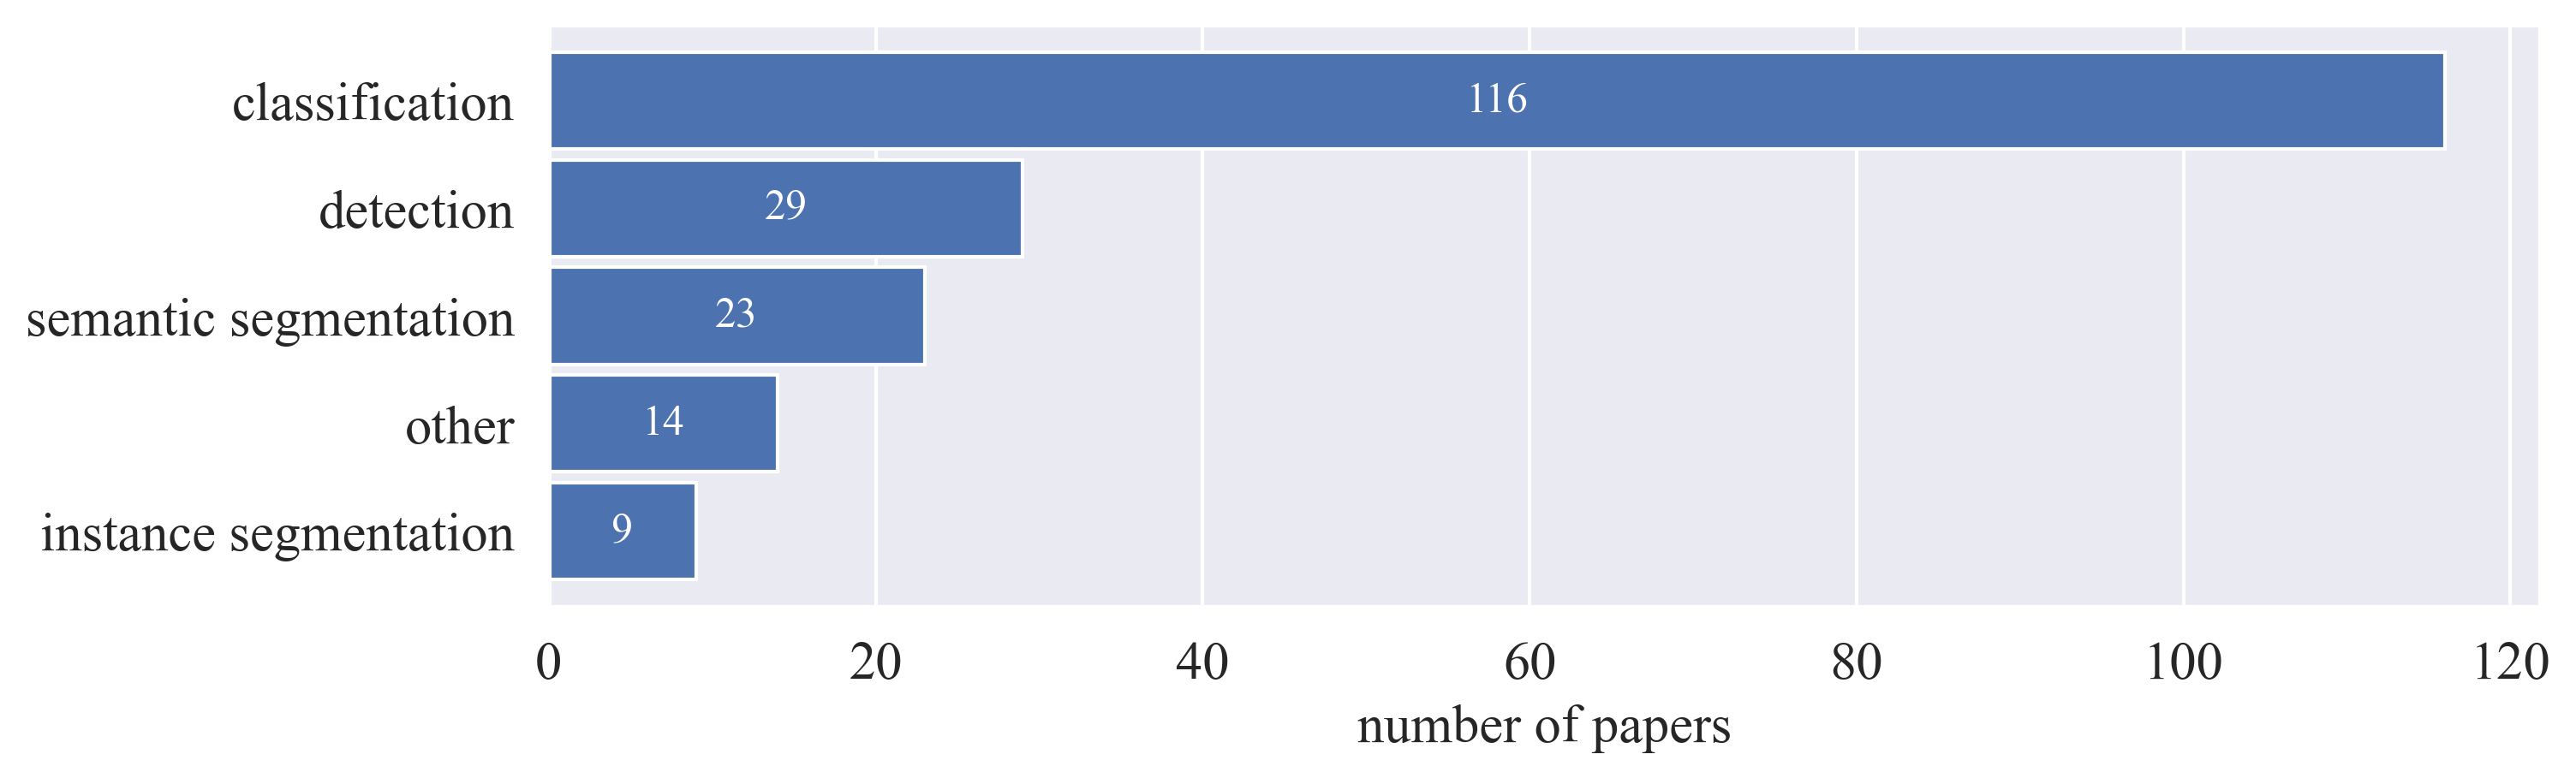

In [14]:
title = "Tasks"
fontsize = 15
figsize = (10, 3)

ax = plotable.plot.barh(rot=0, fontsize=fontsize, figsize=figsize, width=0.9)
ax.set_xlabel('number of papers', fontsize=fontsize)
ax.yaxis.grid(False)
ax.bar_label(ax.containers[0], label_type='center',color='white')
fig = ax.get_figure()
fig.savefig(title+'.png', bbox_inches='tight')

In [15]:
# what are the other tasks?
tasks_other = raw[raw['Code'] == r'Task\other']
tasks_other['Kommentar']

Dokumentname
Brück et al. - 2021 - Machine Learning of Bone Marrow Histopath                                           regression
Marzahl et al. - 2019 - Classification of Leukemic B-Lymphoblas    Bounding Box regression for the (single) cells...
Sadafi et al. - 2019 - Multiclass Deep Active Learning for Dete    develop a score that helps select those images...
Sirinukunwattana et al. - 2020 - Artificial intelligence–based     autoencoder for megacoryocites (cells of inter...
Tomczak et al. - 2020 - Multi-task multi-domain learning for di                                     digital staining
Zhang et al. - 2020 - Corruption-Robust Enhancement of Deep Neu    mix of "novel" augmentation-combination-method...
Gräbel et al. - 2021 - Surrounding Cell Suppression For Unsuper    unsupervised (self supervised) representation ...
Gräbel et al. - 2021 - Reduction of Stain Variability in Bone M                       reduction of stain variability
Gräbel et al. - 2021 - Rotation Invariance for Unsu

### Programming Language

In [16]:
# how many papers report language? how many report multiple?
df_counts['language'].value_counts()

1.0    70
2.0     9
Name: language, dtype: int64

In [17]:
plotable = raw[raw['Code'] == 'language']['Segment'].value_counts().iloc[::-1]

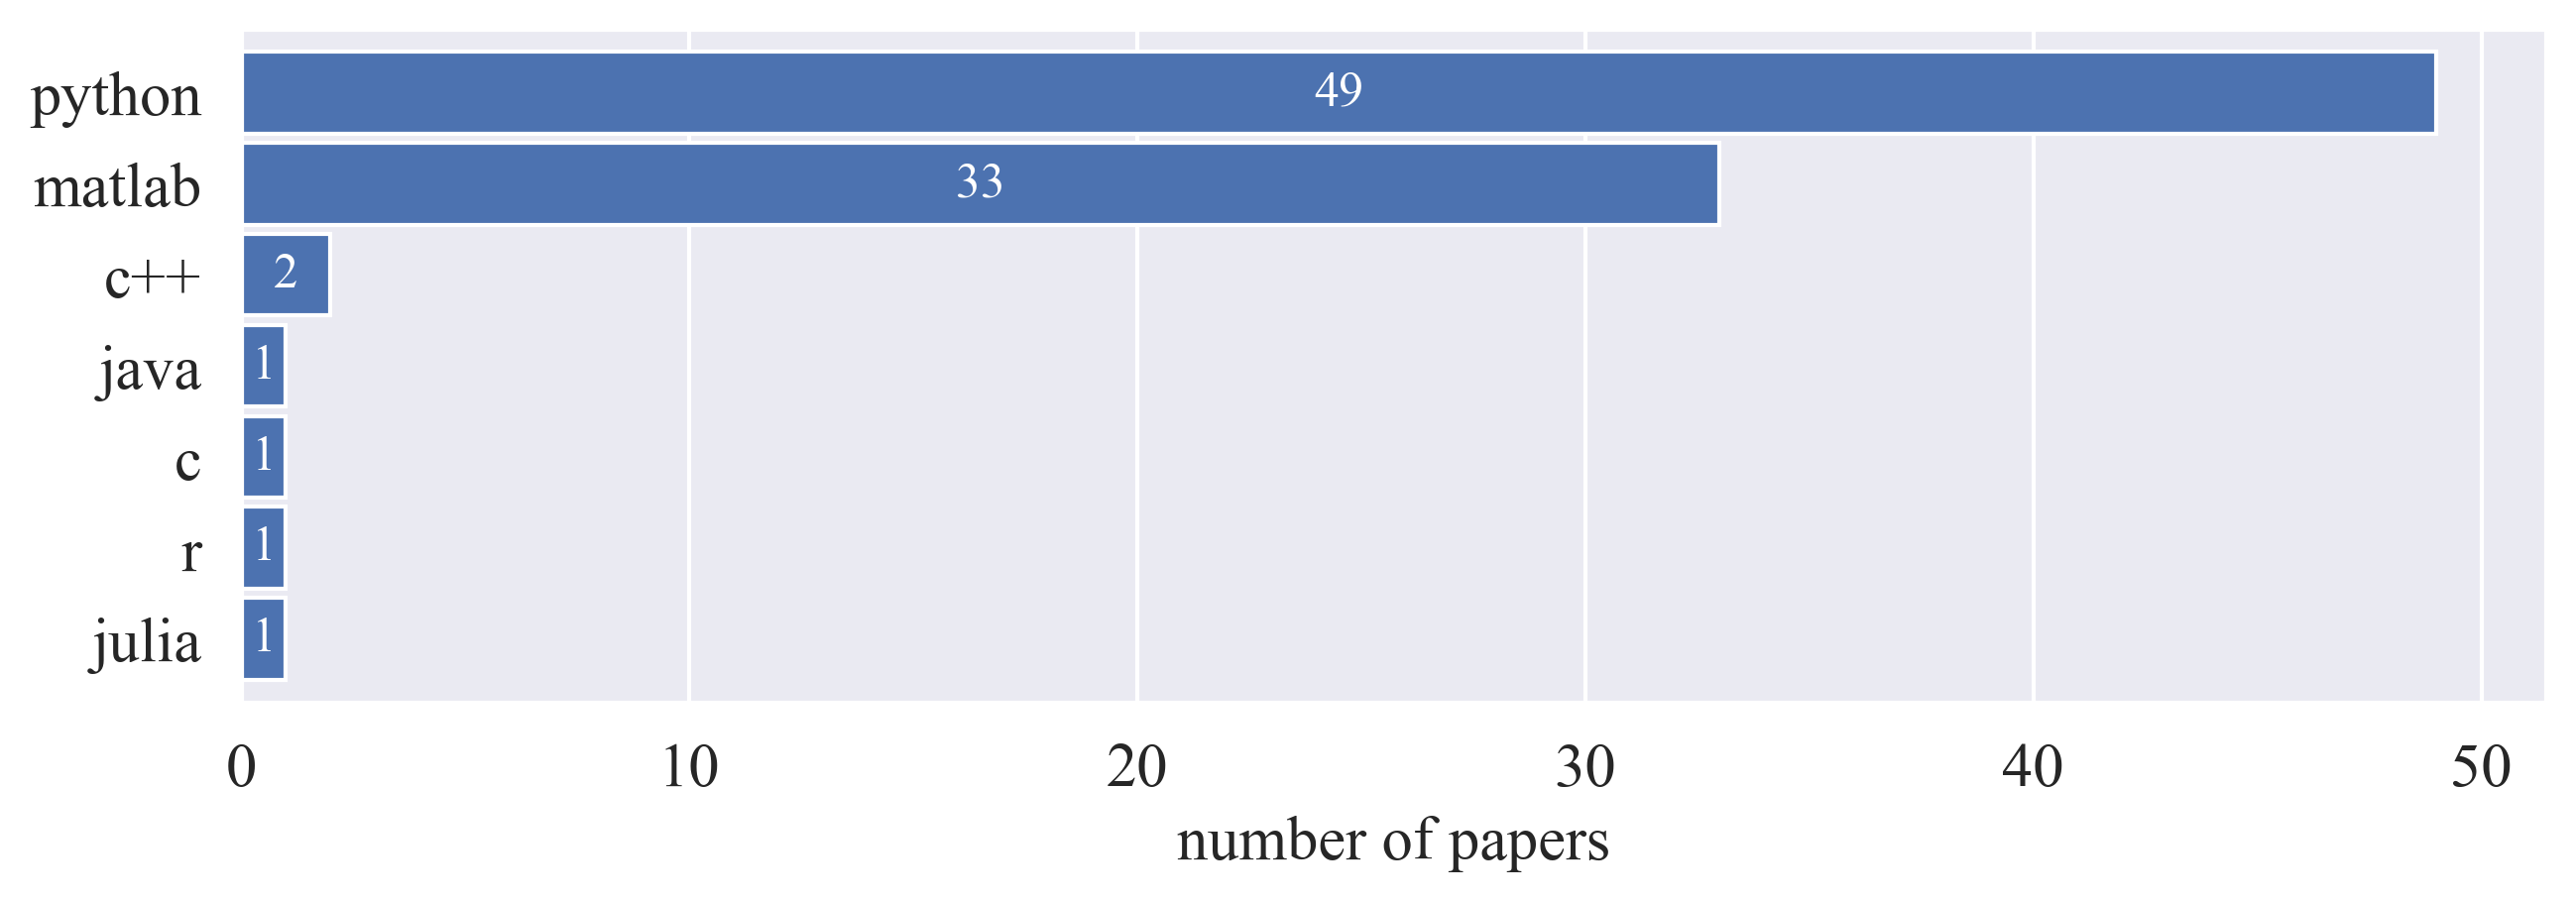

In [18]:
title = "language"
fontsize = 15
figsize = (10, 3)

ax = plotable.plot.barh(rot=0, fontsize=fontsize, figsize=figsize, width=0.9)
ax.set_xlabel('number of papers', fontsize=fontsize)
ax.yaxis.grid(False)
ax.bar_label(ax.containers[0], label_type='center',color='white')
fig = ax.get_figure()
fig.savefig(title+'.png', bbox_inches='tight')

### Framework

In [19]:
# find cooccurences
# pivot to documentname x framework
test = pd.DataFrame(raw.loc[(raw['Code'] == 'Framework','Segment')])
new = test.set_index([test.index, 'Segment'])
new['ones'] = np.ones(len(new))
new = new.unstack(fill_value=0)
new = new.droplevel(0,axis=1)
# co-occurence matrix
df_asint = new.astype(int)
coocc = df_asint.T.dot(df_asint)
coocc = coocc.drop(['computer vision toolbox', 'deep network designer','medical detection toolkit','neural network toolbox','statistics and machine learning toolbox','torch7','weka'])
coocc = coocc.drop(['computer vision toolbox', 'deep network designer','medical detection toolkit','neural network toolbox','statistics and machine learning toolbox','torch7','weka'],axis=1)
coocc

Segment,caffe,darknet,fastai,keras,lasagne,luminoth,mxnet,pytorch,tensorflow,theano
Segment,,,,,,,,,,
caffe,7,1,0,0,0,0,0,0,0,0
darknet,1,2,0,0,0,0,0,0,0,0
fastai,0,0,2,0,0,0,0,1,0,0
keras,0,0,0,33,0,0,0,1,24,0
lasagne,0,0,0,0,1,0,0,0,0,1
luminoth,0,0,0,0,0,1,0,0,1,0
mxnet,0,0,0,0,0,0,2,1,0,0
pytorch,0,0,1,1,0,0,1,14,0,0
tensorflow,0,0,0,24,0,1,0,0,39,0


In [20]:
# how many papers report a framework
len(pd.DataFrame(raw.loc[(raw['Code'] == 'Framework','Segment')]).index.unique())

81

In [21]:
backend_subtraction = pd.Series({'tensorflow':25,
           'pytorch':1,
          'theano':1})
backend_subtraction

tensorflow    25
pytorch        1
theano         1
dtype: int64

In [22]:
plotable = pd.DataFrame({'frameworks':raw.loc[(raw['Code'] == 'Framework','Segment')].value_counts(),'backends':backend_subtraction}).sort_values('frameworks')
plotable['backends'] = plotable['backends'].fillna(0)
plotable = plotable.astype('int')
plotable['frameworks'] = plotable['frameworks'] - plotable['backends']
plotable

,frameworks,backends
medical detection toolkit,1,0
computer vision toolbox,1,0
deep network designer,1,0
statistics and machine learning toolbox,1,0
neural network toolbox,1,0
lasagne,1,0
luminoth,1,0
torch7,1,0
theano,1,1
weka,2,0


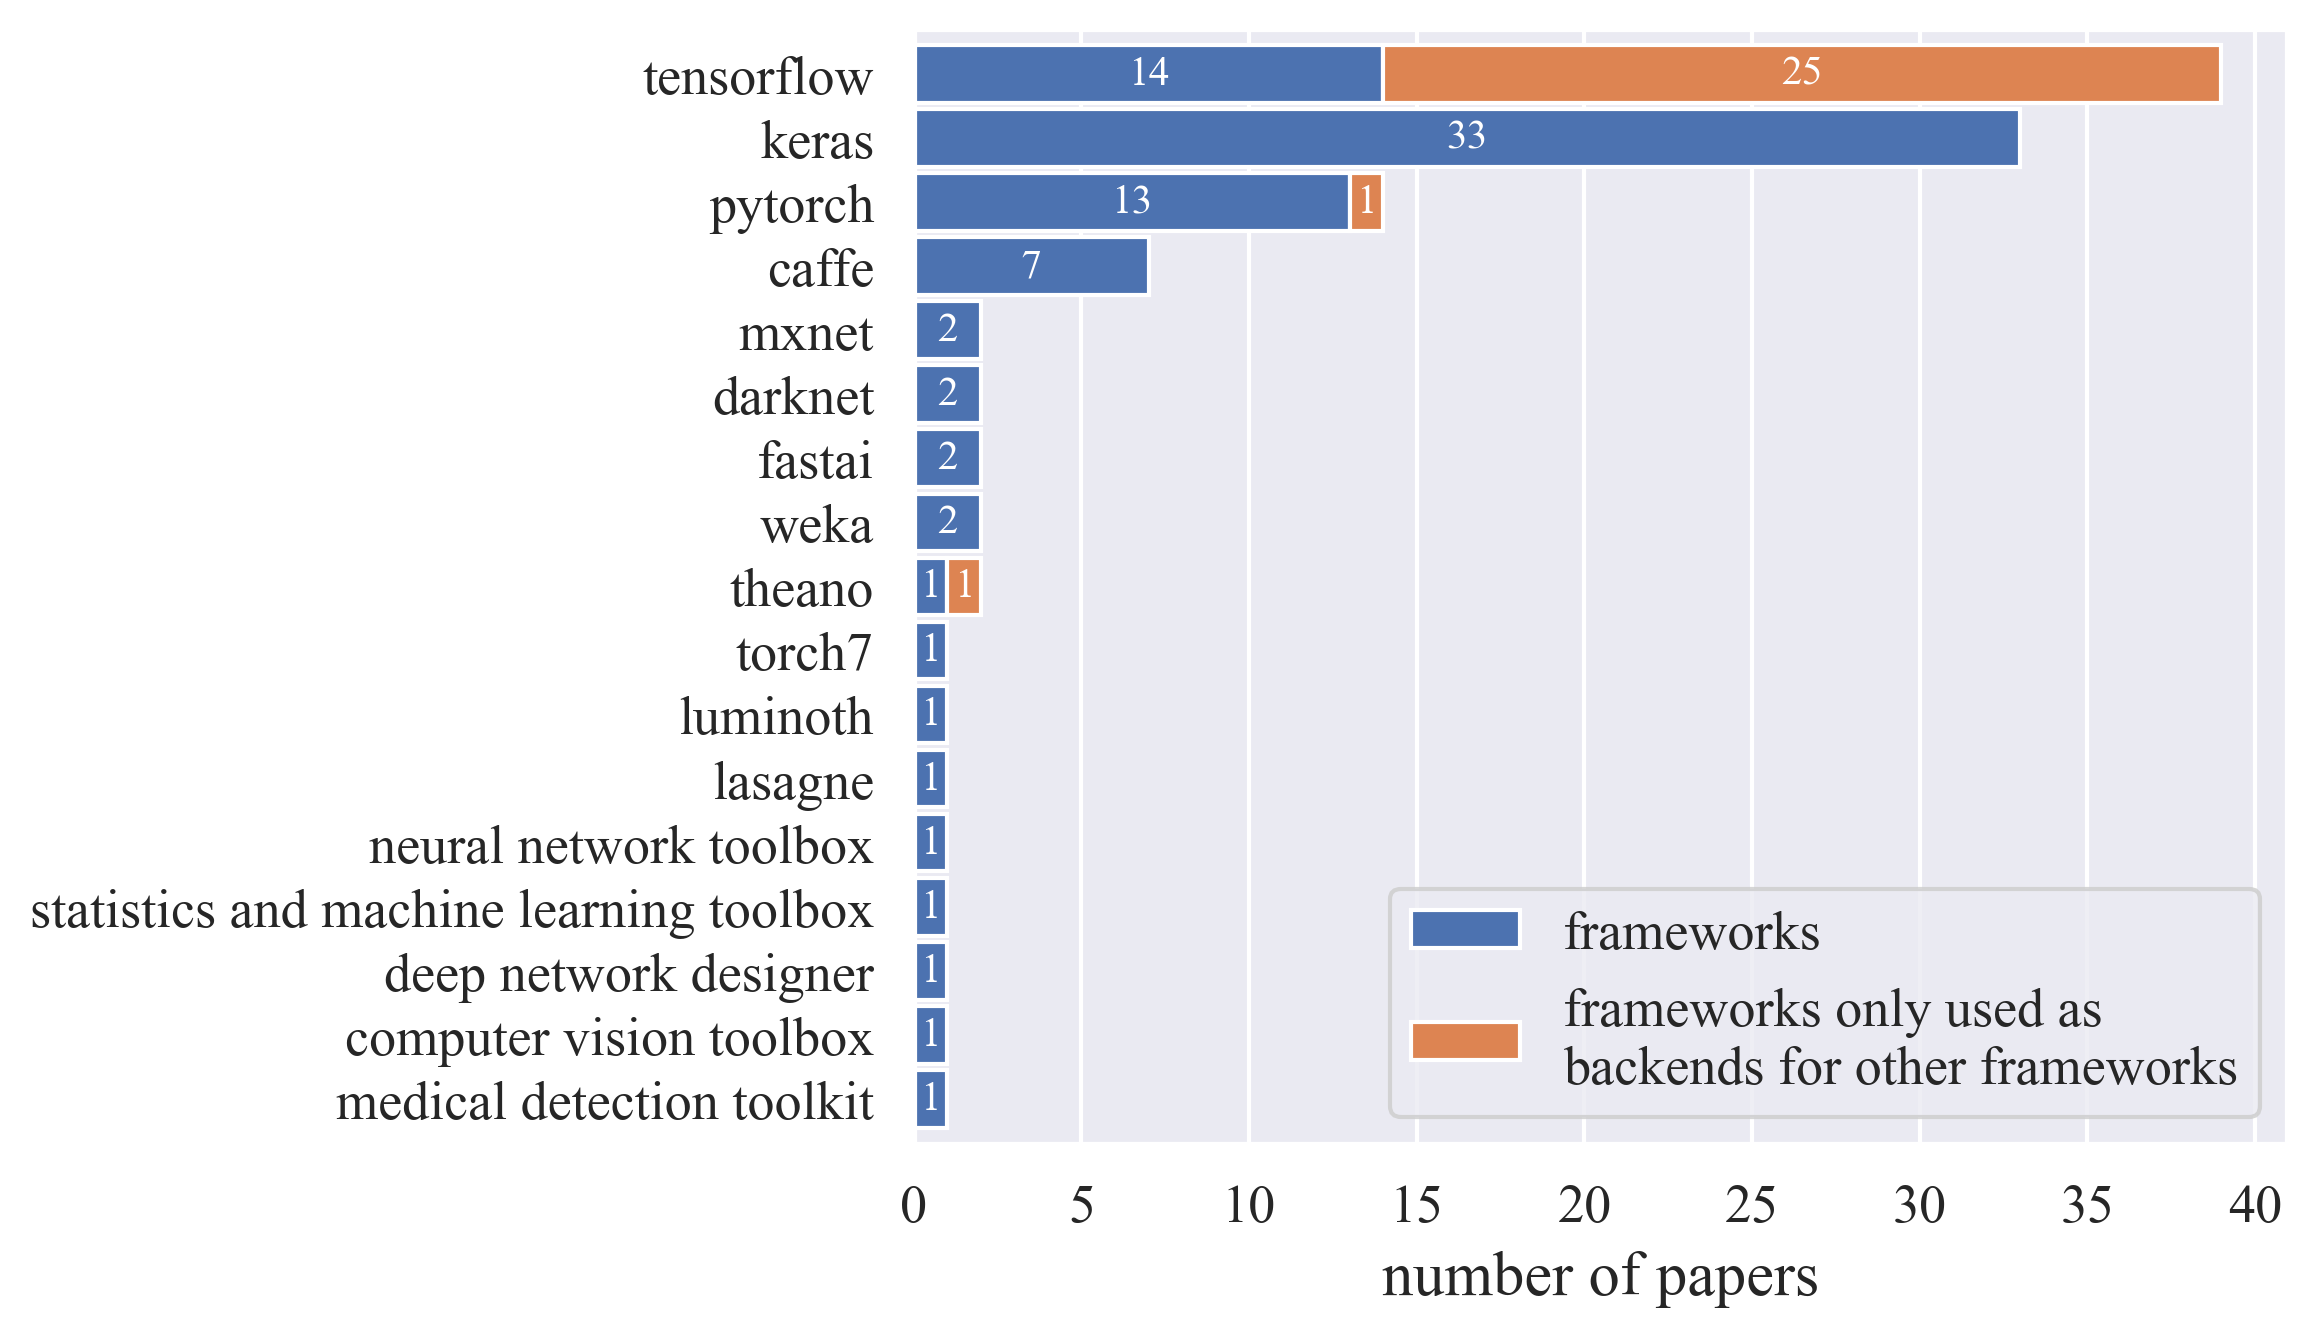

In [23]:
fontsize=15
fontsize_m=13
fontsize_s=10

title = "framework"
#figsize = (10, 5)
figsize=(5.90551, 5.90551/1.2)

ax = plotable.plot.barh(fontsize=fontsize_m, figsize=figsize, stacked=True, width=0.9)
ax.set_xlabel('number of papers', fontsize=fontsize)
ax.yaxis.grid(False)
ax.bar_label(ax.containers[0],size=fontsize_s, label_type='center',color='white')
ax.bar_label(ax.containers[1], ['' if x==0 else int(x) for x in plotable.iloc[:,1]], size=fontsize_s, label_type='center',color='white')
ax.legend(['frameworks','frameworks only used as \nbackends for other frameworks'],fontsize=fontsize_m,loc='lower right')
fig = ax.get_figure()
fig.savefig(title+'.png', bbox_inches='tight')

In [24]:
# multiple framework mentions in papers
df_counts['Framework'].value_counts()

1.0    51
2.0    30
Name: Framework, dtype: int64

### Hyperparametertuning

In [25]:
df_counts['hyperparametertuning'].value_counts()

1.0    7
2.0    2
Name: hyperparametertuning, dtype: int64

In [26]:
# too few values for a plot, just make it a table. A paragraph takes  even less space since the table is not compressable
# (only repeating entry is "random search" and even that is only 3 occurences)
raw.loc[(raw['Code'] == 'hyperparametertuning','Segment')]

Dokumentname
Gräbel et al. - 2020 - Circular Anchors for the Detection of He                         hyper-parameter optimization
Kasani et al. - 2020 - An Aggregated-Based Deep Learning Method                                          grid-search
Kumar et al. - 2020 - CNN-SSPSO A Hybrid and Optimized CNN Appr                                 Salp Swarm Algorithm
Kumar et al. - 2020 - CNN-SSPSO A Hybrid and Optimized CNN Appr                               Cat Swarm Optimization
Prellberg und Kramer - 2019 - Acute Lymphoblastic Leukemia Clas    Hyperparameters for the training procedure hav...
Silva et al. - 2020 - Optimizing data augmentation policies for                                Bayesian optimization
Sipes und Li - 2018 - Using Convolutional Neural Networks for A                                       random search 
Bani-Hani et al. - 2018 - Classification of Leucocytes Using Co       GA was applied for hyperparameter optimization
Gräbel et al. - 2018 - Evaluating Out-of-the-Box Me

### Models

In [27]:
#df_counts[r'models\name'].value_counts()
#df_counts[r'models\modified version of (name)'].value_counts()
#df_counts[r'models\custom'].value_counts()
#df_counts[r'models\not further specified'].value_counts()

In [28]:
# how many papers use named/modified/custom models?
models = df_counts[[r'models\name',r'models\modified version of (name)',r'models\custom']].count()
models

Code
models\name                          106
models\modified version of (name)     32
models\custom                         58
dtype: int64

In [29]:
# how many papers report on model architecture?
models = df_counts[[r'models\name',r'models\modified version of (name)',r'models\custom']]
len(models[models.notna().any(axis=1)])

160

In [30]:
# which papers have more than 1 task? use to annotate (comment) which mentioned models belong to which task. This allows differentiating in the chapter
# tasks[tasks.count(axis=1) >= 2]

In [31]:
# named models
# get models mentioned in classification papers
filtered_1 = raw.loc[(raw['Code'] == r'models\name')][tasks[r'Task\classification'].notna()]
# not all models in class. papers are class. models, because some class. papers do other DL tasks aswell (det/seg/...) -> filter those out using comments from maxqda
filtered_2 = filtered_1[-filtered_1['Kommentar'].isin(['seg','seg class backbone','det','seg backbone','det backbone','Backbone for autoencoder'])]
# only segment column
df_class = filtered_2['Segment'].value_counts()

# same for det/semseg/instseg/gen
filtered_1 = raw.loc[(raw['Code'] == r'models\name')][tasks[r'Task\detection'].notna()]
filtered_2 = filtered_1[-filtered_1['Kommentar'].isin(['seg','seg class backbone','class','seg backbone','Backbone for autoencoder'])]
df_det = filtered_2['Segment'].value_counts()

filtered_1 = raw.loc[(raw['Code'] == r'models\name')][tasks[r'Task\segmentation\semantic'].notna()]
filtered_2 = filtered_1[-filtered_1['Kommentar'].isin(['det','class','det backbone','Backbone for autoencoder','seg in','seg instance backbone'])]
df_semseg = filtered_2['Segment'].value_counts()

filtered_1 = raw.loc[(raw['Code'] == r'models\name')][tasks[r'Task\segmentation\instance'].notna()]
filtered_2 = filtered_1[-filtered_1['Kommentar'].isin(['det','class','det backbone','Backbone for autoencoder','seg sem'])]
df_insseg = filtered_2['Segment'].value_counts()

<ipython-input-31-1a8cef327f43>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_1 = raw.loc[(raw['Code'] == r'models\name')][tasks[r'Task\classification'].notna()]
<ipython-input-31-1a8cef327f43>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_1 = raw.loc[(raw['Code'] == r'models\name')][tasks[r'Task\detection'].notna()]
<ipython-input-31-1a8cef327f43>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_1 = raw.loc[(raw['Code'] == r'models\name')][tasks[r'Task\segmentation\semantic'].notna()]
<ipython-input-31-1a8cef327f43>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_1 = raw.loc[(raw['Code'] == r'models\name')][tasks[r'Task\segmentation\instance'].notna()]


In [32]:
# modified models
# get models mentioned in classification papers
filtered_1 = raw.loc[(raw['Code'] == r'models\modified version of (name)')][tasks[r'Task\classification'].notna()]
# not all models in class. papers are class. models, because some class. papers do other DL tasks aswell (det/seg/...) -> filter those out using comments from maxqda
filtered_2 = filtered_1[-filtered_1['Kommentar'].isin(['det (mask head disabled)'])]
# only segment column
df_class2 = filtered_2['Segment'].value_counts()

# same for det/semseg/instseg/gen
filtered_1 = raw.loc[(raw['Code'] == r'models\modified version of (name)')][tasks[r'Task\detection'].notna()]
filtered_2 = filtered_1
df_det2 = filtered_2['Segment'].value_counts()

filtered_1 = raw.loc[(raw['Code'] == r'models\modified version of (name)')][tasks[r'Task\segmentation\semantic'].notna()]
filtered_2 = filtered_1
df_semseg2 = filtered_2['Segment'].value_counts()

filtered_1 = raw.loc[(raw['Code'] == r'models\modified version of (name)')][tasks[r'Task\segmentation\instance'].notna()]
filtered_2 = filtered_1
df_insseg2 = filtered_2['Segment'].value_counts()

<ipython-input-32-6f5c672747ca>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_1 = raw.loc[(raw['Code'] == r'models\modified version of (name)')][tasks[r'Task\classification'].notna()]
<ipython-input-32-6f5c672747ca>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_1 = raw.loc[(raw['Code'] == r'models\modified version of (name)')][tasks[r'Task\detection'].notna()]
<ipython-input-32-6f5c672747ca>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_1 = raw.loc[(raw['Code'] == r'models\modified version of (name)')][tasks[r'Task\segmentation\semantic'].notna()]
<ipython-input-32-6f5c672747ca>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_1 = raw.loc[(raw['Code'] == r'models\modified version of (name)')][tasks[r'Task\segmentation\instance'].notna()]


In [33]:
# put models and modified models into 1 df
plotable1 = pd.DataFrame({'model':df_class, 'modified model':df_class2})
# sum counts over both vars
plotable1['sum'] = plotable1.sum(axis=1)
# drop lines (models) if they occur less than twice
plotable1 = plotable1[plotable1['sum'] > 1]
# sort
plotable1 = plotable1.sort_values('sum')
# drop sum column
plotable1 = plotable1.drop('sum', axis=1)

plotable2 = pd.DataFrame({'model':df_det, 'modified model':df_det2})
plotable2['sum'] = plotable2.sum(axis=1)
plotable2 = plotable2[plotable2['sum'] > 1]
plotable2 = plotable2.sort_values('sum')
plotable2 = plotable2.drop('sum', axis=1)

plotable3 = pd.DataFrame({'model':df_semseg, 'modified model':df_semseg2})
plotable3['sum'] = plotable3.sum(axis=1)
plotable3 = plotable3[plotable3['sum'] > 1]
plotable3 = plotable3.sort_values('sum')
plotable3 = plotable3.drop('sum', axis=1)

plotable4 = pd.DataFrame({'model':df_insseg, 'modified model':df_insseg2})
plotable4['sum'] = plotable4.sum(axis=1)
plotable4 = plotable4[plotable4['sum'] > 1]
plotable4 = plotable4.sort_values('sum')
plotable4 = plotable4.drop('sum', axis=1)

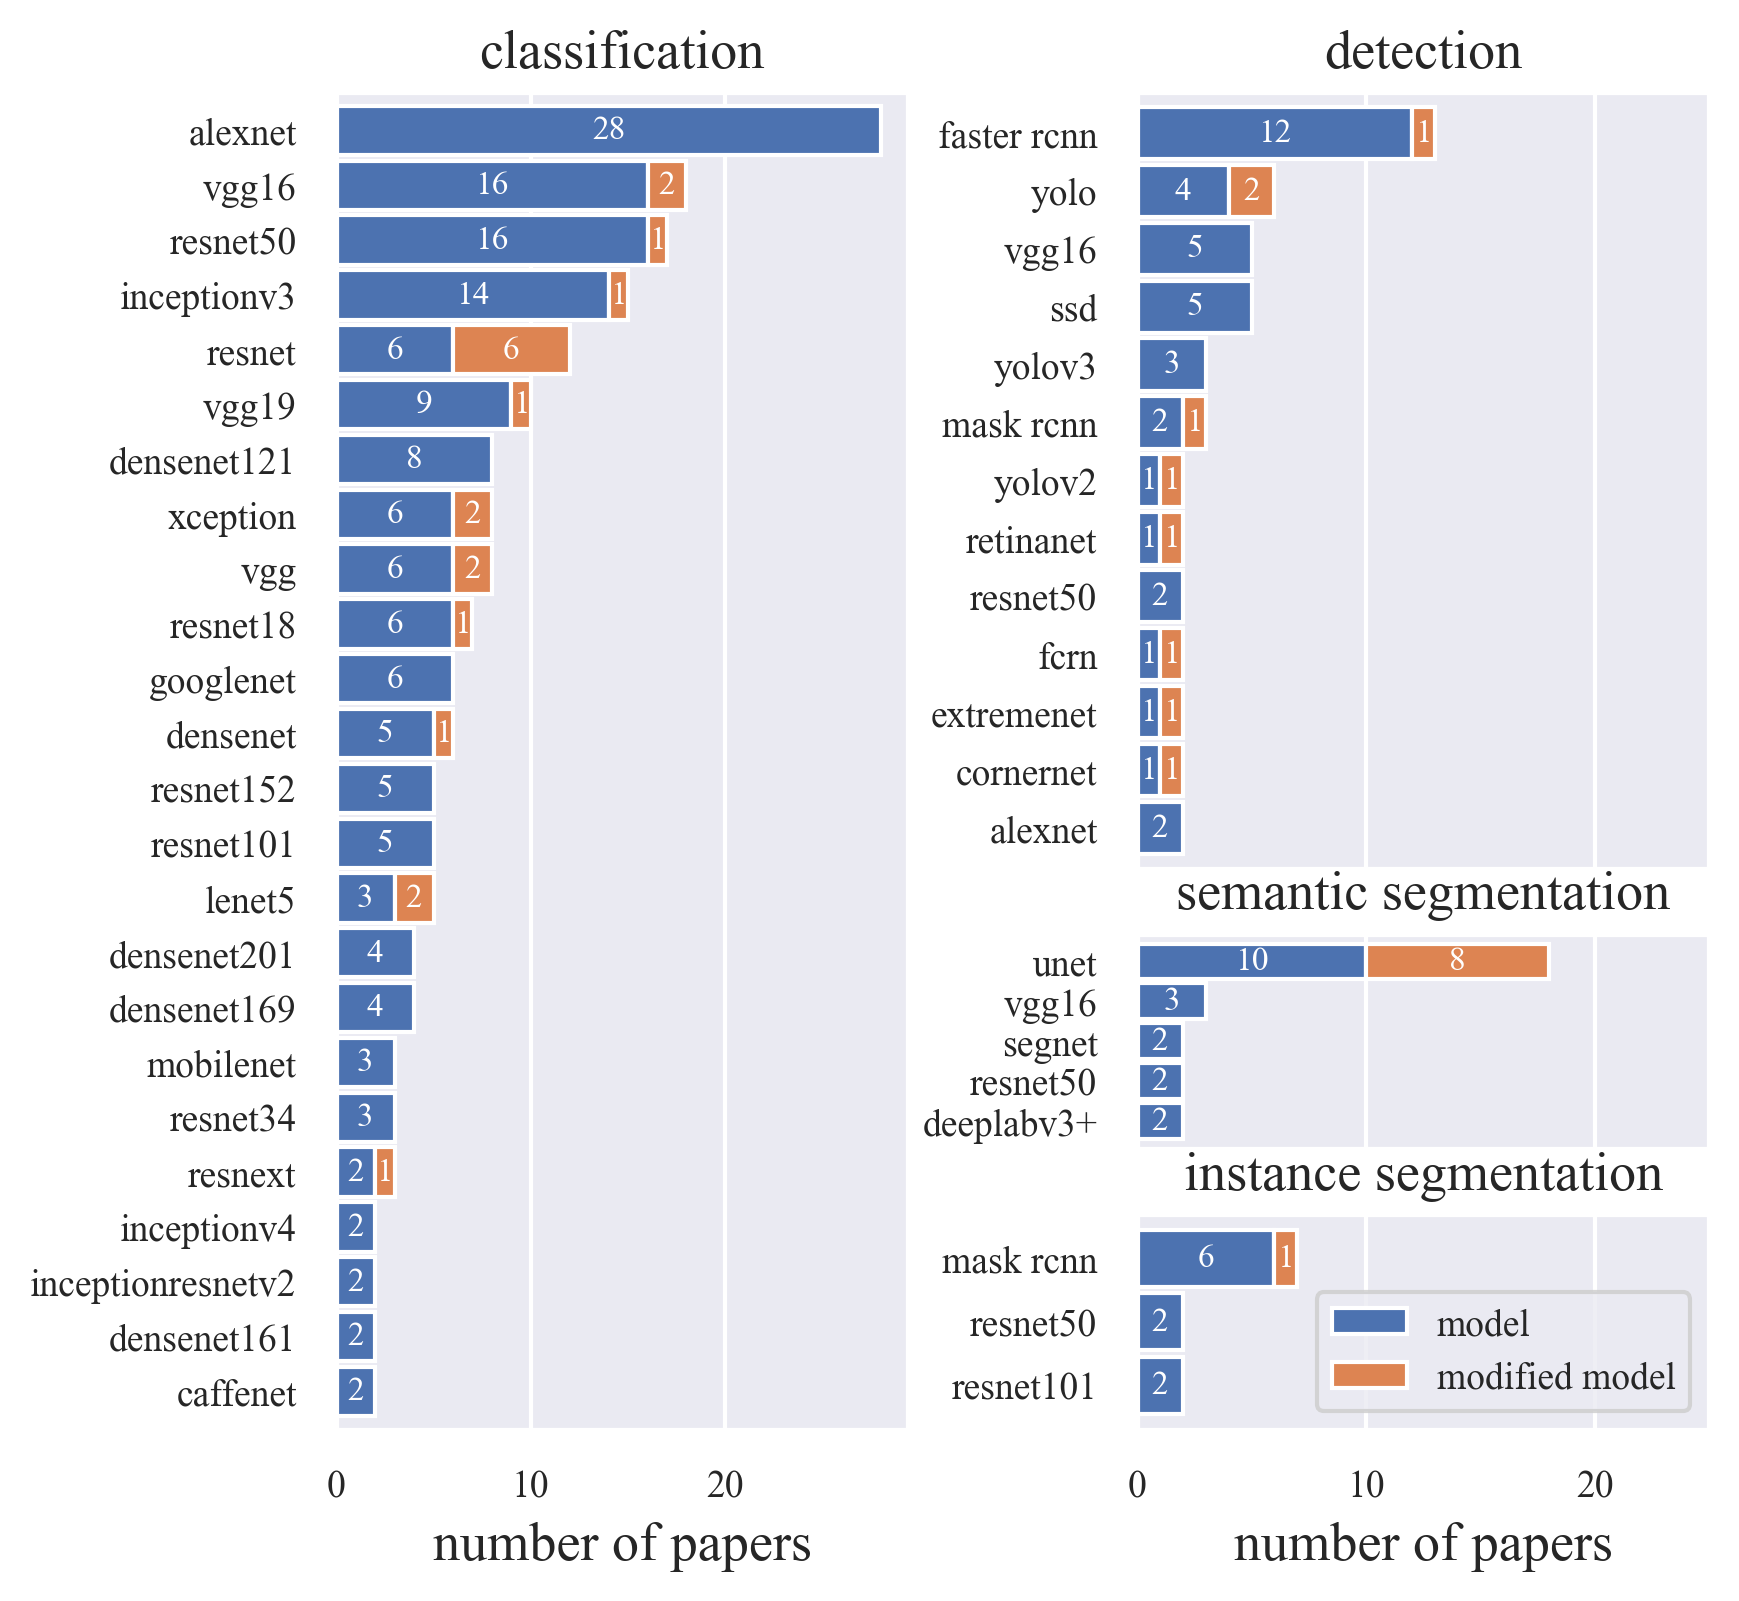

In [34]:
fontsize=13
fontsize_m=9
fontsize_s=8

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
fig = plt.figure(figsize=(5.90551, 5.90551))
gs = GridSpec(nrows=5, ncols=2,wspace=0.4,hspace=0.3)
ax0 = fig.add_subplot(gs[:,0])
plotable1.plot.barh(fontsize=fontsize_m,stacked=True,ax=ax0,legend=False, width=0.9)
ax0.set_xlabel('number of papers', fontsize=fontsize)
ax0.yaxis.grid(False)
ax0.set_title('classification', fontsize=fontsize)
ax0.bar_label(ax0.containers[0],size=fontsize_s, label_type='center',color='white')
ax0.bar_label(ax0.containers[1], ['' if math.isnan(x) else int(x) for x in plotable1.iloc[:,1]], size=fontsize_s, label_type='center',color='white')
ax1 = fig.add_subplot(gs[0:3, 1])
plotable2.plot.barh(fontsize=fontsize_m,stacked=True,ax=ax1,legend=False, width=0.9)
ax1.set_xlim([0, 25])
ax1.yaxis.grid(False)
ax1.set_title('detection', fontsize=fontsize)
ax1.bar_label(ax1.containers[0],size=fontsize_s, label_type='center',color='white')
ax1.bar_label(ax1.containers[1], ['' if math.isnan(x) else int(x) for x in plotable2.iloc[:,1]],size=fontsize_s, label_type='center',color='white')
ax2 = fig.add_subplot(gs[3, 1])
plotable3.plot.barh(fontsize=fontsize_m,stacked=True,ax=ax2,legend=False, width=0.9)
ax2.sharex(ax1)
ax2.yaxis.grid(False)
ax2.set_title('semantic segmentation', fontsize=fontsize)
ax2.bar_label(ax2.containers[0],size=fontsize_s, label_type='center',color='white')
ax2.bar_label(ax2.containers[1], ['' if math.isnan(x) else int(x) for x in plotable3.iloc[:,1]],size=fontsize_s, label_type='center',color='white')
ax3 = fig.add_subplot(gs[4, 1])
plotable4.plot.barh(fontsize=fontsize_m,stacked=True,ax=ax3, width=0.9)
ax3.sharex(ax1)
ax3.set_xlabel('number of papers', fontsize=fontsize)
ax3.yaxis.grid(False)
ax3.set_title('instance segmentation', fontsize=fontsize)
ax3.bar_label(ax3.containers[0],size=fontsize_s, label_type='center',color='white')
ax3.bar_label(ax3.containers[1], ['' if math.isnan(x) else int(x) for x in plotable4.iloc[:,1]],size=fontsize_s, label_type='center',color='white')
ax3.legend(fontsize=fontsize_m,loc='lower right')

fig.savefig('model_name.png', bbox_inches='tight')

In [35]:
# repeat above but with the model (depth) numbers cut off
plotable1.index = plotable1.index.str.replace('\d+', '')
plotable1.index = plotable1.index.str.replace('v$', '')
plotable1 = plotable1.groupby(plotable1.index).sum()
plotable1['sum'] = plotable1.sum(axis=1)
plotable1 = plotable1[plotable1['sum'] > 1]
# sort
plotable1 = plotable1.sort_values('sum')
# drop sum column
plotable1 = plotable1.drop('sum', axis=1)


# repeat above but with the model (depth) numbers cut off
plotable2.index = plotable2.index.str.replace('\d+', '')
plotable2.index = plotable2.index.str.replace('v$', '')
plotable2 = plotable2.groupby(plotable2.index).sum()
plotable2['sum'] = plotable2.sum(axis=1)
plotable2 = plotable2[plotable2['sum'] > 1]
# sort
plotable2 = plotable2.sort_values('sum')
# drop sum column
plotable2 = plotable2.drop('sum', axis=1)

# repeat above but with the model (depth) numbers cut off
plotable3.index = plotable3.index.str.replace('\d+', '')
plotable3.index = plotable3.index.str.replace('v$', '')
plotable3 = plotable3.groupby(plotable3.index).sum()
plotable3['sum'] = plotable3.sum(axis=1)
plotable3 = plotable3[plotable3['sum'] > 1]
# sort
plotable3 = plotable3.sort_values('sum')
# drop sum column
plotable3 = plotable3.drop('sum', axis=1)

# repeat above but with the model (depth) numbers cut off
plotable4.index = plotable4.index.str.replace('\d+', '')
plotable4.index = plotable4.index.str.replace('v$', '')
plotable4 = plotable4.groupby(plotable4.index).sum()
plotable4['sum'] = plotable4.sum(axis=1)
plotable4 = plotable4[plotable4['sum'] > 1]
# sort
plotable4 = plotable4.sort_values('sum')
# drop sum column
plotable4 = plotable4.drop('sum', axis=1)

<ipython-input-35-25689bdc56bf>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  plotable1.index = plotable1.index.str.replace('\d+', '')
<ipython-input-35-25689bdc56bf>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  plotable1.index = plotable1.index.str.replace('v$', '')
<ipython-input-35-25689bdc56bf>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  plotable2.index = plotable2.index.str.replace('\d+', '')
<ipython-input-35-25689bdc56bf>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  plotable2.index = plotable2.index.str.replace('v$', '')
<ipython-input-35-25689bdc56bf>:25: FutureWarning: The default value of regex will change from True to False in a future version.
  plotable3.index = plotable3.index.str.replace('\d+', '')
<ipython-input-35-25689bdc56bf>:26: FutureWarning: The defa

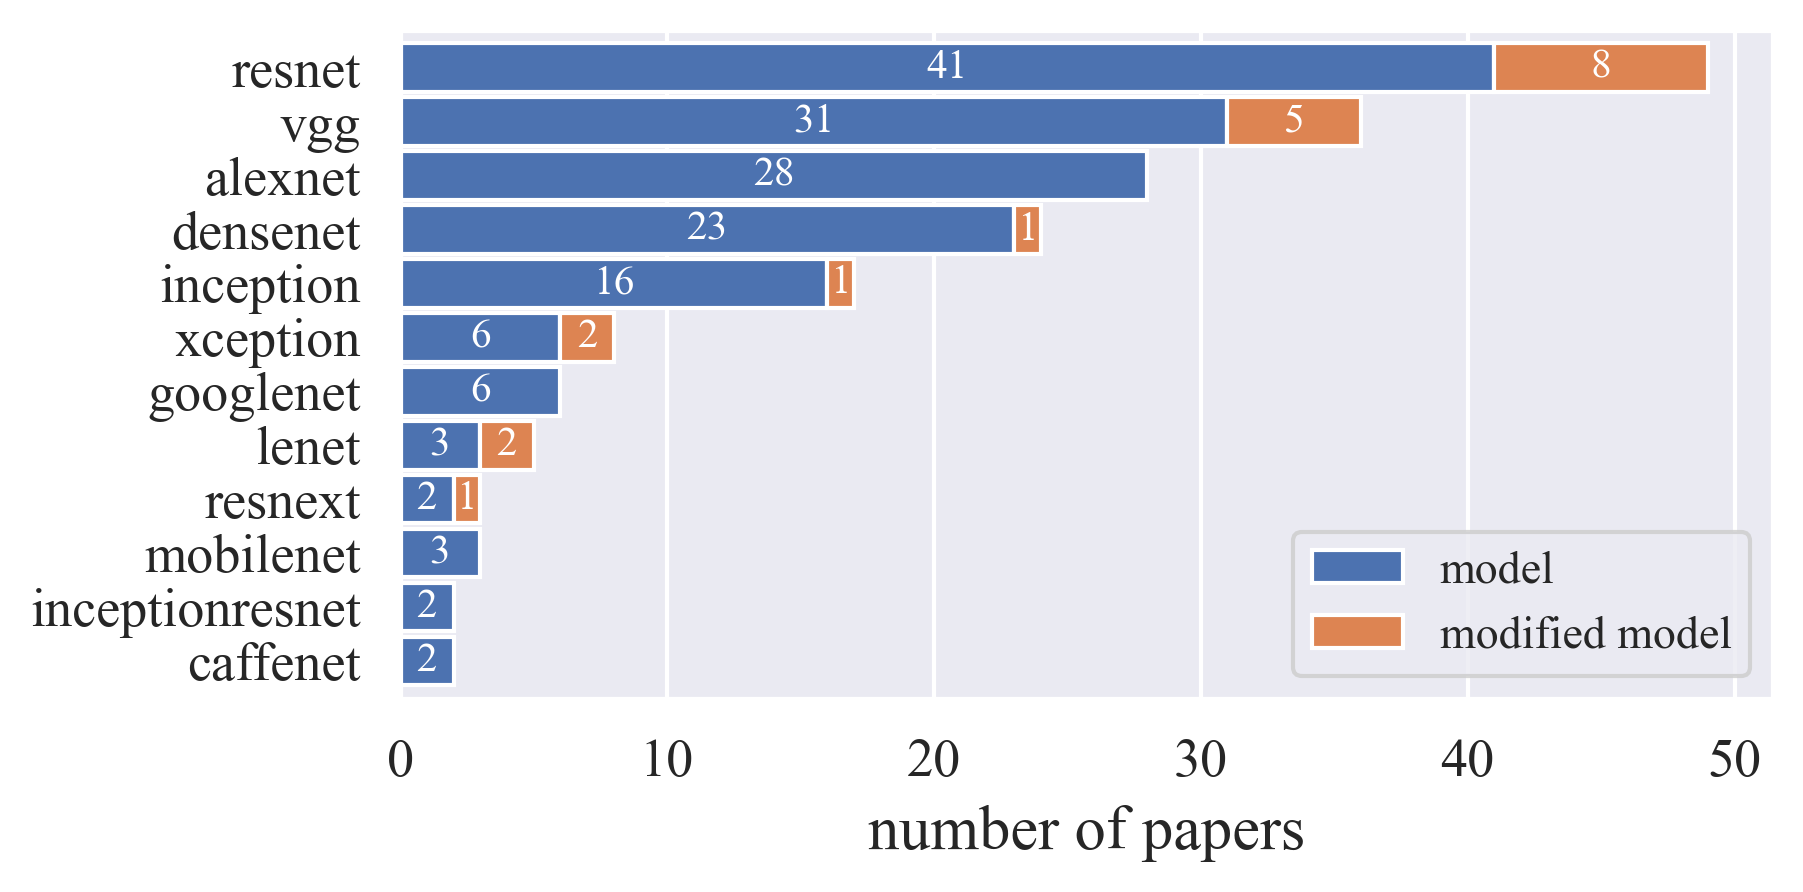

In [36]:
#fontsize=13
#fontsize_m=9
#fontsize_s=8

fontsize=15
fontsize_m=13
fontsize_s=10

title = "model_name_aggregated"
figsize=(5.90551, 5.90551/2)

ax = plotable1.plot.barh(fontsize=fontsize_m, figsize=figsize, stacked=True, width=0.9)
ax.set_xlabel('number of papers', fontsize=fontsize)
ax.yaxis.grid(False)
ax.bar_label(ax.containers[0],size=fontsize_s, label_type='center',color='white')
ax.bar_label(ax.containers[1], ['' if x==0 else int(x) for x in plotable1.iloc[:,1]], size=fontsize_s, label_type='center',color='white')
#ax.legend(['frameworks','frameworks only used as \nbackends for other frameworks'],fontsize=fontsize_m,loc='lower right')
fig = ax.get_figure()
fig.savefig(title+'.png', bbox_inches='tight')


### Type of Validation

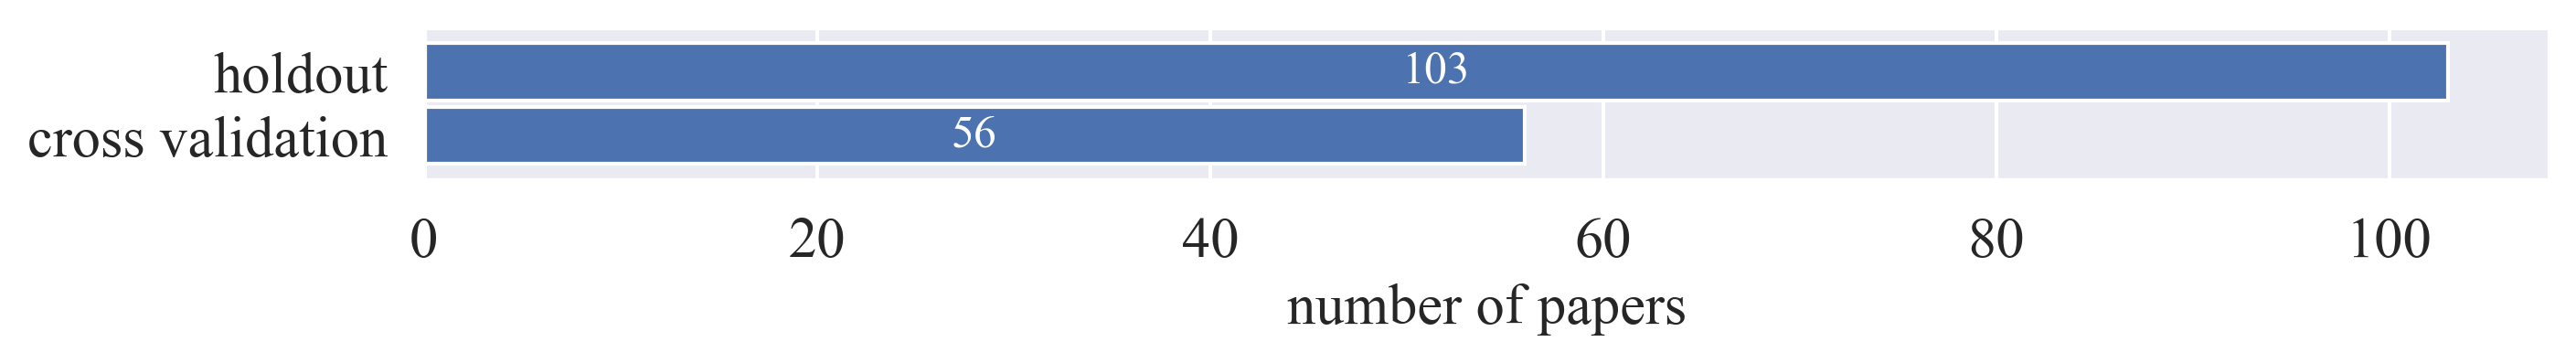

In [37]:
# which type of validation how often
validation = df_counts[[r'evaluation\type\holdout',r'evaluation\type\cross validation']]
plotable = validation.sum().sort_values()
plotable.index = [x[-1] for x in plotable.index.str.split('\\')] # clean names up

title = "validation"
fontsize = 15
figsize=(10, 5.90551/8)

ax = plotable.plot.barh(rot=0, fontsize=fontsize, figsize=figsize, width=0.9)
ax.set_xlabel('number of papers', fontsize=fontsize)
ax.yaxis.grid(False)
ax.bar_label(ax.containers[0], label_type='center',color='white')
fig = ax.get_figure()
fig.savefig(title+'.png', bbox_inches='tight')

In [38]:
# how many report which kind of validation they use
len(validation[validation.sum(axis=1) > 0])

159

In [39]:
# which papers don't report kind of validation
validation[validation.sum(axis=1) == 0]

Code,evaluation\type\holdout,evaluation\type\cross validation
Dokumentname,,
Al-Qudah und Suen - 2020 - Synthetic Blood Smears Generation Us,NaN,NaN
Fu et al. - 2020 - Morphogo An Automatic Bone Marrow Cell Class,NaN,NaN
Lin et al. - 2018 - Leukocyte recognition with convolutional ne,NaN,NaN
Naz et al. - 2019 - Robust Discrimination of Leukocytes Protube,NaN,NaN
Sadafi et al. - 2019 - Multiclass Deep Active Learning for Dete,NaN,NaN
Sharif et al. - 2020 - Recognition of Different Types of Leukoc,NaN,NaN
Wang et al. - 2018 - SO-YOLO Based WBC Detection With Fourier P,NaN,NaN


In [40]:
# which report multiple
validation[validation.sum(axis=1) > 1]

Code,evaluation\type\holdout,evaluation\type\cross validation
Dokumentname,,


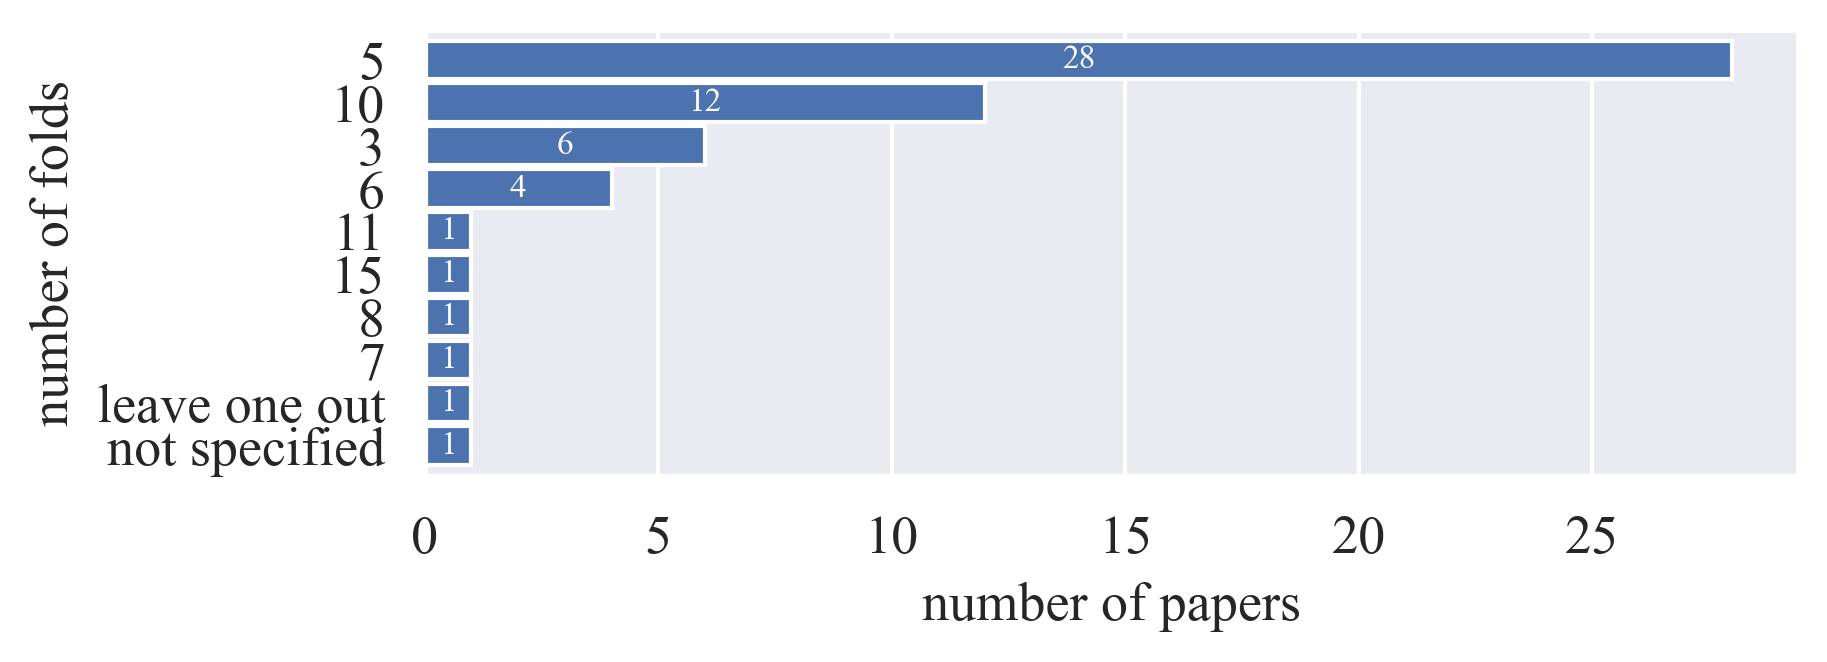

In [41]:
# cross validation how many folds
plotable = raw.loc[(raw['Code']==r'evaluation\type\cross validation','Kommentar')].value_counts()
plotable = plotable.sort_values()
# move strings to bottom to make plot look cleaner
new_index = plotable.index.to_list()
new_index.insert(0, new_index.pop(plotable.index.to_list().index('leave one out')))
new_index.insert(0, new_index.pop(plotable.index.to_list().index('not specified')))
plotable = plotable.reindex(new_index)

title = "cross validation"
fontsize = 13
figsize=(5.90551, 5.90551/3)

ax = plotable.plot.barh(rot=0, fontsize=fontsize, figsize=figsize, width=0.9)
ax.set_xlabel('number of papers', fontsize=fontsize)
ax.set_ylabel('number of folds', fontsize=fontsize)
ax.yaxis.grid(False)
ax.bar_label(ax.containers[0], label_type='center',color='white', fontsize=fontsize-5)
fig = ax.get_figure()
fig.savefig(title+'.png', bbox_inches='tight')

### Metrics

In [42]:
# which papers have more than 1 task? use to annotate (comment) which mentioned metrics belong to which task. This allows differentiating in the chapter
tasks[tasks.count(axis=1) >= 2]

,Task\classification,Task\other,Task\detection,Task\segmentation\instance,Task\segmentation\semantic
Dokumentname,,,,,
Alemi Koohbanani et al. - 2020 - NuClick A deep learning framew,NaN,NaN,NaN,1.0,1.0
Almezhghwi und Serte - 2020 - Improved Classification of White,1.0,1.0,NaN,NaN,NaN
Baydilli et al. - 2019 - Improving classification performance o,1.0,1.0,NaN,NaN,NaN
Chandradevan et al. - 2020 - Machine-based detection and classi,1.0,NaN,1.0,NaN,NaN
Gräbel et al. - 2021 - Reduction of Stain Variability in Bone M,1.0,1.0,NaN,1.0,NaN
Gräbel et al. - 2021 - Rotation Invariance for Unsupervised Cel,1.0,1.0,NaN,NaN,NaN
Gräbel et al. - 2021 - Surrounding Cell Suppression For Unsuper,1.0,1.0,NaN,NaN,NaN
He et al. - 2020 - CellIdNet Automatic Cell Instance Segmentati,1.0,NaN,NaN,1.0,NaN
He et al. - 2020 - CycleGAN With an Improved Loss Function for,NaN,1.0,1.0,NaN,NaN


In [43]:
# named models
# get models mentioned in classification papers
filtered_1 = raw.loc[(raw['Code'] == r'evaluation\metric')][tasks[r'Task\classification'].notna()]
filtered_1['Kommentar'].value_counts()
# not all metrics in class. papers are class. metrics, because some class. papers do other DL tasks aswell (det/seg/...) -> filter those out using comments from maxqda
filtered_2 = filtered_1[-filtered_1['Kommentar'].isin(['seg','det','metric for reconstruction'])]
# drop duplicate index-value pairs. Only occurs when the same metric is used multiple times in the same paper for different tasks.
# this can only happen when the authors used 
# only segment column
df_class = filtered_2['Segment'].value_counts()

<ipython-input-43-27edcdeb345a>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_1 = raw.loc[(raw['Code'] == r'evaluation\metric')][tasks[r'Task\classification'].notna()]


In [44]:
# same for det/semseg/instseg/gen
filtered_1 = raw.loc[(raw['Code'] == r'evaluation\metric')][tasks[r'Task\detection'].notna()]
filtered_2 = filtered_1[-filtered_1['Kommentar'].isin(['seg','class','seg backbone'])]
df_det = filtered_2['Segment'].value_counts()

filtered_1 = raw.loc[(raw['Code'] == r'evaluation\metric')][tasks[r'Task\segmentation\semantic'].notna()]
filtered_2 = filtered_1[-filtered_1['Kommentar'].isin(['class','seg in','seg instance backbone','det','in seg'])]
df_semseg = filtered_2['Segment'].value_counts()

filtered_1 = raw.loc[(raw['Code'] == r'evaluation\metric')][tasks[r'Task\segmentation\instance'].notna()]
filtered_2 = filtered_1[-filtered_1['Kommentar'].isin(['class','seg sem','sem seg'])]
df_insseg = filtered_2['Segment'].value_counts()

<ipython-input-44-ddce50b88a5b>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_1 = raw.loc[(raw['Code'] == r'evaluation\metric')][tasks[r'Task\detection'].notna()]
<ipython-input-44-ddce50b88a5b>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_1 = raw.loc[(raw['Code'] == r'evaluation\metric')][tasks[r'Task\segmentation\semantic'].notna()]
<ipython-input-44-ddce50b88a5b>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_1 = raw.loc[(raw['Code'] == r'evaluation\metric')][tasks[r'Task\segmentation\instance'].notna()]


filtered_1 = raw.loc[(raw['Code'] == r'evaluation\metric')][tasks[r'Task\detection'].notna()]
filtered_2 = filtered_1[-filtered_1['Kommentar'].isin(['seg','class','seg backbone'])]
filtered_2['Segment'][filtered_2['Segment']=='Accuracy']

filtered_1 = raw.loc[(raw['Code'] == r'evaluation\metric')][tasks[r'Task\segmentation\semantic'].notna()]
filtered_2 = filtered_1[-filtered_1['Kommentar'].isin(['class','seg in','seg instance backbone','det','in seg'])]
filtered_2['Segment'][filtered_2['Segment']=='F-Score']

In [45]:
filtered_1 = raw.loc[(raw['Code'] == r'evaluation\metric')][tasks[r'Task\segmentation\instance'].notna()]
filtered_2 = filtered_1[-filtered_1['Kommentar'].isin(['class','seg sem','sem seg'])]
filtered_2['Segment'][filtered_2['Segment']=='Jaccard']

<ipython-input-45-e2a1072ba362>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_1 = raw.loc[(raw['Code'] == r'evaluation\metric')][tasks[r'Task\segmentation\instance'].notna()]


Dokumentname
Fan et al. - 2019 - LeukocyteMask An automated localization and    Jaccard
He et al. - 2020 - CellIdNet Automatic Cell Instance Segmentati    Jaccard
Name: Segment, dtype: object

In [46]:
# put models and modified models into 1 df
plotable1 = df_class
# only keep top 6 most used metrics
plotable1 = plotable1.iloc[:5]
# sort
plotable1 = plotable1.sort_values()

plotable2 = df_det
plotable2 = plotable2.iloc[:5]
plotable2 = plotable2.sort_values()

plotable3 = df_semseg
plotable3 = plotable3.iloc[:5]
plotable3 = plotable3.sort_values()

plotable4 = df_insseg#.iloc[:6].drop('Hausdorff') # FIXME
plotable4 = plotable4.iloc[:5]
plotable4 = plotable4.sort_values()

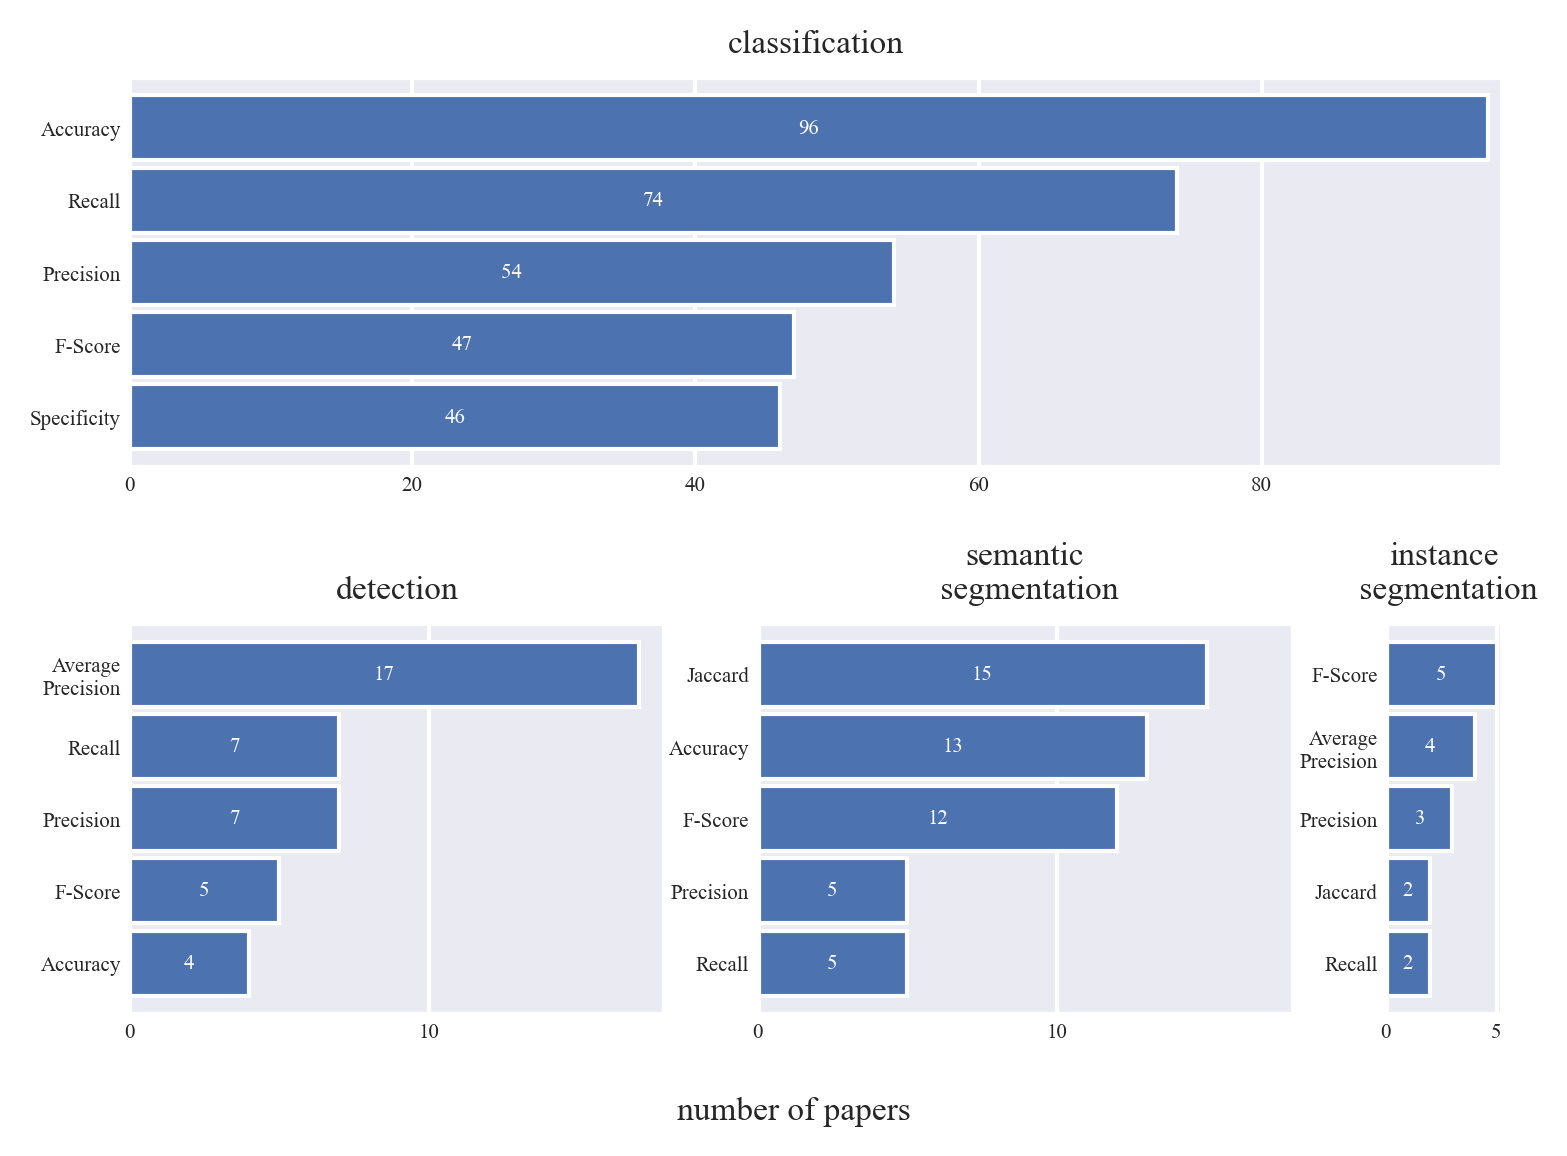

In [47]:
fontsize=8
fontsize_m=5
fontsize_s=5

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
fig = plt.figure(figsize=(5.90551, 5.90551*0.7))
gs = GridSpec(nrows=2, ncols=7,wspace=0.8,hspace=0.4)
ax0 = fig.add_subplot(gs[0,:])
ax0.set_xlim([0, int(plotable1.max())+1])
plotable1.plot.barh(fontsize=fontsize_m,stacked=True,ax=ax0,legend=False, width=0.9)
ax0.tick_params(axis='both', which='major', pad=-4)
ax0.yaxis.grid(False)
ax0.set_title('classification', fontsize=fontsize)
ax0.bar_label(ax0.containers[0],size=fontsize_s, label_type='center',color='white')
#ax0.bar_label(ax0.containers[1], ['' if math.isnan(x) else int(x) for x in plotable1.iloc[:,1]], size=fontsize_s, label_type='center',color='white')
ax1 = fig.add_subplot(gs[1, :3])
plotable2.plot.barh(fontsize=fontsize_m,stacked=True,ax=ax1,legend=False, width=0.9)
ax1.tick_params(axis='both', which='major', pad=-4)
#ax1.sharex(ax0)
ax1.yaxis.grid(False)
ax1.set_title('detection', fontsize=fontsize)
ax1.bar_label(ax1.containers[0],size=fontsize_s, label_type='center',color='white')
#ax1.bar_label(ax1.containers[1], ['' if math.isnan(x) else int(x) for x in plotable2.iloc[:,1]],size=fontsize_s, label_type='center',color='white')
ax2 = fig.add_subplot(gs[1, 3:6])
plotable3.plot.barh(fontsize=fontsize_m,stacked=True,ax=ax2,legend=False, width=0.9)
ax2.tick_params(axis='both', which='major', pad=-4)
ax2.sharex(ax1)
ax2.yaxis.grid(False)
ax2.set_title('semantic\n segmentation', fontsize=fontsize)
ax2.bar_label(ax2.containers[0],size=fontsize_s, label_type='center',color='white')
#ax2.bar_label(ax2.containers[1], ['' if math.isnan(x) else int(x) for x in plotable3.iloc[:,1]],size=fontsize_s, label_type='center',color='white')
ax3 = fig.add_subplot(gs[1, 6])
plotable4.plot.barh(fontsize=fontsize_m,stacked=True,ax=ax3, width=0.9)
ax3.tick_params(axis='both', which='major', pad=-4)
#ax3.sharex(ax1)
ax3.yaxis.grid(False)
ax3.set_title('instance\n segmentation', fontsize=fontsize)
ax3.bar_label(ax3.containers[0],size=fontsize_s, label_type='center',color='white')
#ax3.bar_label(ax3.containers[1], ['' if math.isnan(x) else int(x) for x in plotable4.iloc[:,1]],size=fontsize_s, label_type='center',color='white')
#ax3.legend(fontsize=fontsize_m,loc='lower right')

fig.text(0.5, 0.04, 'number of papers', ha='center', fontsize=fontsize)

fig.savefig('metrics.png', bbox_inches='tight')

### Feature Visualization

In [48]:
# how many features vis entries
print(len(raw.loc[(raw['Code'] == r'feature visualization')]))
# how many papers use more than 1 technique?
print(np.count_nonzero(raw.loc[(raw['Code'] == r'feature visualization')].index.duplicated()))
# which
raw.loc[(raw['Code'] == r'feature visualization')]

14
1


,Code,Segment,Kommentar
Dokumentname,,,
Matek et al. - 2019 - Human-level recognition of blast cells in,feature visualization,saliency maps following the procedure outlined...,saliency map (Simonyan)
Acevedo et al. - 2019 - Recognition of peripheral blood cell im,feature visualization,Visualization of intermediate feature maps,feature map inspection
Bao et al. - 2019 - Morphology-based classification of mycobact,feature visualization,The CNN-recognized high active signals were re...,deconvolution
Cao et al. - 2020 - FPB Improving Multi-Scale Feature Represent,feature visualization,Visualization results of class activate mapping,CAM
Fan et al. - 2019 - LeukocyteMask An automated localization and,feature visualization,Examples of feature maps extracted from WBC-or...,feature map inspection
Huang et al. - 2020 - Attention-aware Residual Network based Ma,feature visualization,A random selected example obtained by the ARML...,CAM
Shahin et al. - 2019 - White blood cells identification system,feature visualization,comparison of the deep convolutional kernels ...,visualization of weights
Yang et al. - 2021 - Leukocyte subtypes identification using bi,feature visualization,Convolutional feature maps from basenet compar...,feature map inspection
Ye et al. - 2019 - Dual attention based fine-grained leukocyte,feature visualization,Different feature maps and attention masks gen...,feature map inspection


In [49]:
#feature visualization counts
fv = raw.loc[(raw['Code'] == r'feature visualization', 'Kommentar')]
fv = fv.replace('saliency map (Simonyan)','saliency map')
fv = fv.replace('Guided Backprop x input (Shrikumar)','Guided Backprop')
fv_counts = fv.value_counts()
fv_counts

feature map inspection      4
Guided Backprop             2
Grad-CAM                    2
CAM                         2
deconvolution               1
saliency map                1
visualization of weights    1
Guided Grad-CAM             1
Name: Kommentar, dtype: int64

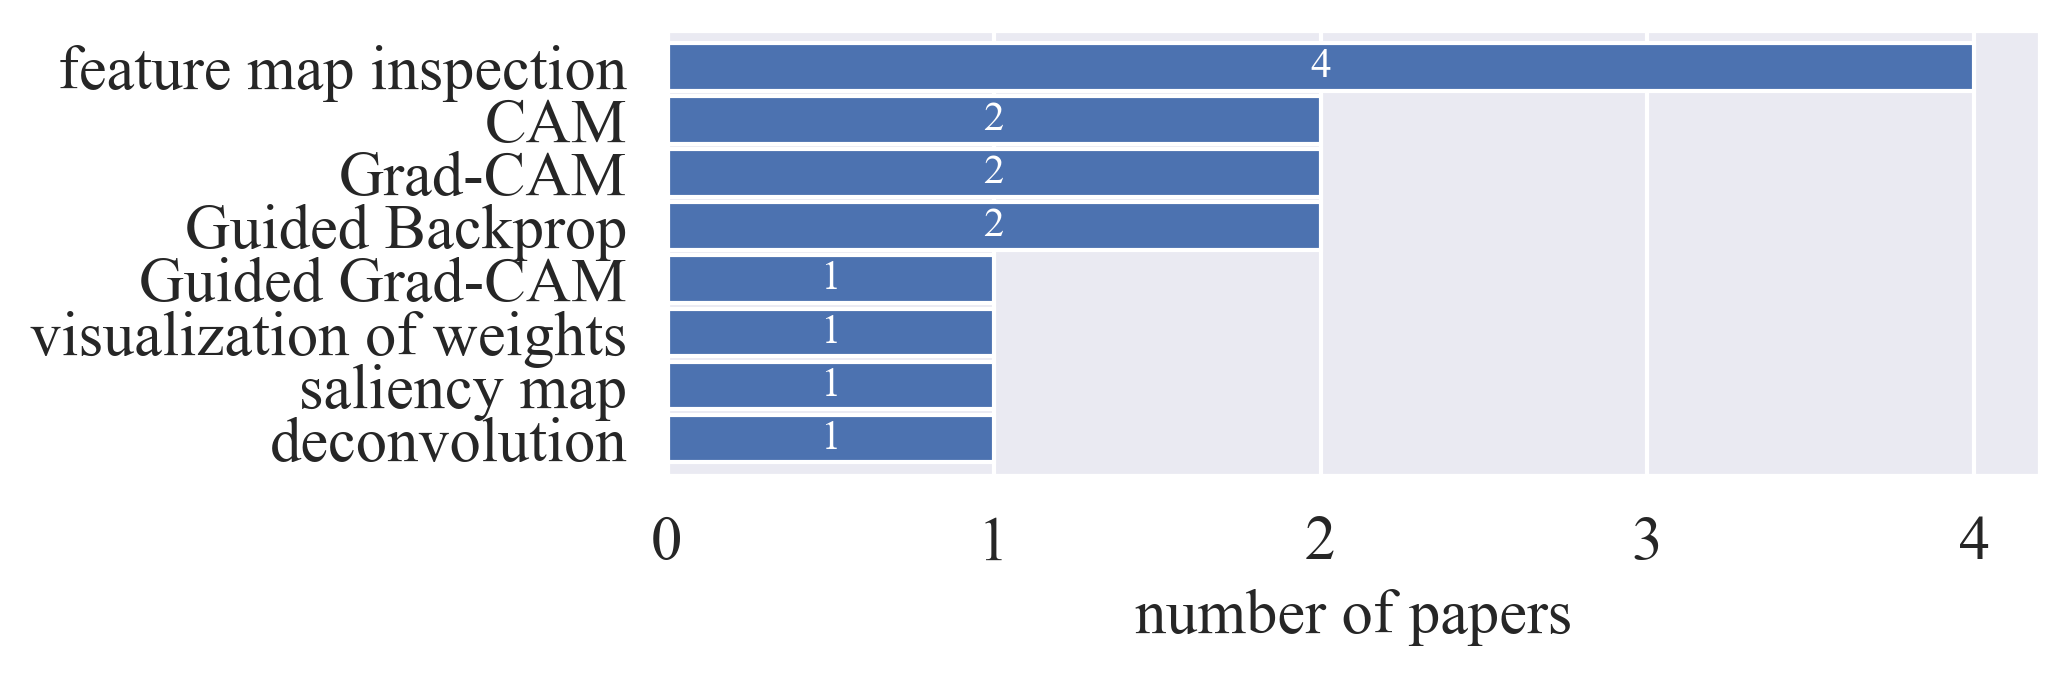

In [50]:
from matplotlib.ticker import MaxNLocator

plotable = fv_counts
plotable = plotable.sort_values()

title = "feature viz"
fontsize = 15
figsize=(5.90551, 5.90551/3)

ax = plt.figure().gca()
ax = plotable.plot.barh(rot=0, fontsize=fontsize, figsize=figsize, width=0.9)
ax.set_xlabel('number of papers', fontsize=fontsize)
ax.yaxis.grid(False)
ax.bar_label(ax.containers[0], label_type='center',color='white', fontsize=fontsize-5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig = ax.get_figure()
fig.savefig(title+'.png', bbox_inches='tight')

### Transfer Learning

In [51]:
# how many do transfer learning
tl = raw.loc[(raw['Code'] == r'transfer learning') | (raw['Code'] == r'transfer learning\scratch') | (raw['Code'] == r'transfer learning\feature extraction') | (raw['Code'] == r'transfer learning\fine tuning')]
tl = tl.reset_index().groupby(['Dokumentname', 'Code'])['Code'].aggregate('first').unstack() # remove duplicate paper entries
print(len(tl))
# how many don't specify details
print(len(raw.loc[(raw['Code'] == r'transfer learning')]))
# which compare transfer learning types or transfer learning to training from scratch

90
21


In [52]:
tl = raw.loc[(raw['Code'] == r'transfer learning') | (raw['Code'] == r'transfer learning\scratch') | (raw['Code'] == r'transfer learning\feature extraction') | (raw['Code'] == r'transfer learning\fine tuning')]
tl = tl.reset_index().groupby(['Dokumentname', 'Code'])['Code'].aggregate('first').unstack().fillna(1)
tl[r'transfer learning\feature extraction'] = pd.to_numeric(tl[r'transfer learning\feature extraction'], errors='coerce')
tl[r'transfer learning\fine tuning'] = pd.to_numeric(tl[r'transfer learning\fine tuning'], errors='coerce')
tl[r'transfer learning\scratch'] = pd.to_numeric(tl[r'transfer learning\scratch'], errors='coerce')
tl[r'transfer learning'] = pd.to_numeric(tl[r'transfer learning'], errors='coerce')
#tl = tl.drop('transfer learning', axis=1)
tl = tl.fillna(0)
tl = tl.astype(int)
tl = tl.replace(1,2)
tl = tl.replace(0,1)
tl = tl.replace(2,0)
tl.index.name=None
tl.columns.name=None
tl = tl.rename(columns={r'transfer learning\feature extraction':'feature extraction', r'transfer learning\fine tuning': 'fine tuning', r'transfer learning\scratch':'from scratch','transfer learning':'not further specified'})
tl

,not further specified,feature extraction,fine tuning,from scratch
Abdulkarim et al. - 2020 - A deep learning AlexNet model for cl,1,0,0,0
Acevedo et al. - 2019 - Recognition of peripheral blood cell im,0,1,1,0
Almezhghwi und Serte - 2020 - Improved Classification of White,0,0,1,1
Alzubaidi et al. - 2020 - Deep Learning Models for Classificati,0,1,1,1
Aziz et al. - 2020 - Deep Learning-based Automatic Morphologica,1,0,0,0
...,...,...,...,...
Yao et al. - 2021 - Classification of white blood cells using w,1,0,0,0
Ye et al. - 2019 - Dual attention based fine-grained leukocyte,0,0,1,0
Yu et al. - 2017 - Automatic classification of leukocytes using,0,0,1,0
Zhao et al. - 2017 - Automatic detection and classification of,0,1,0,0


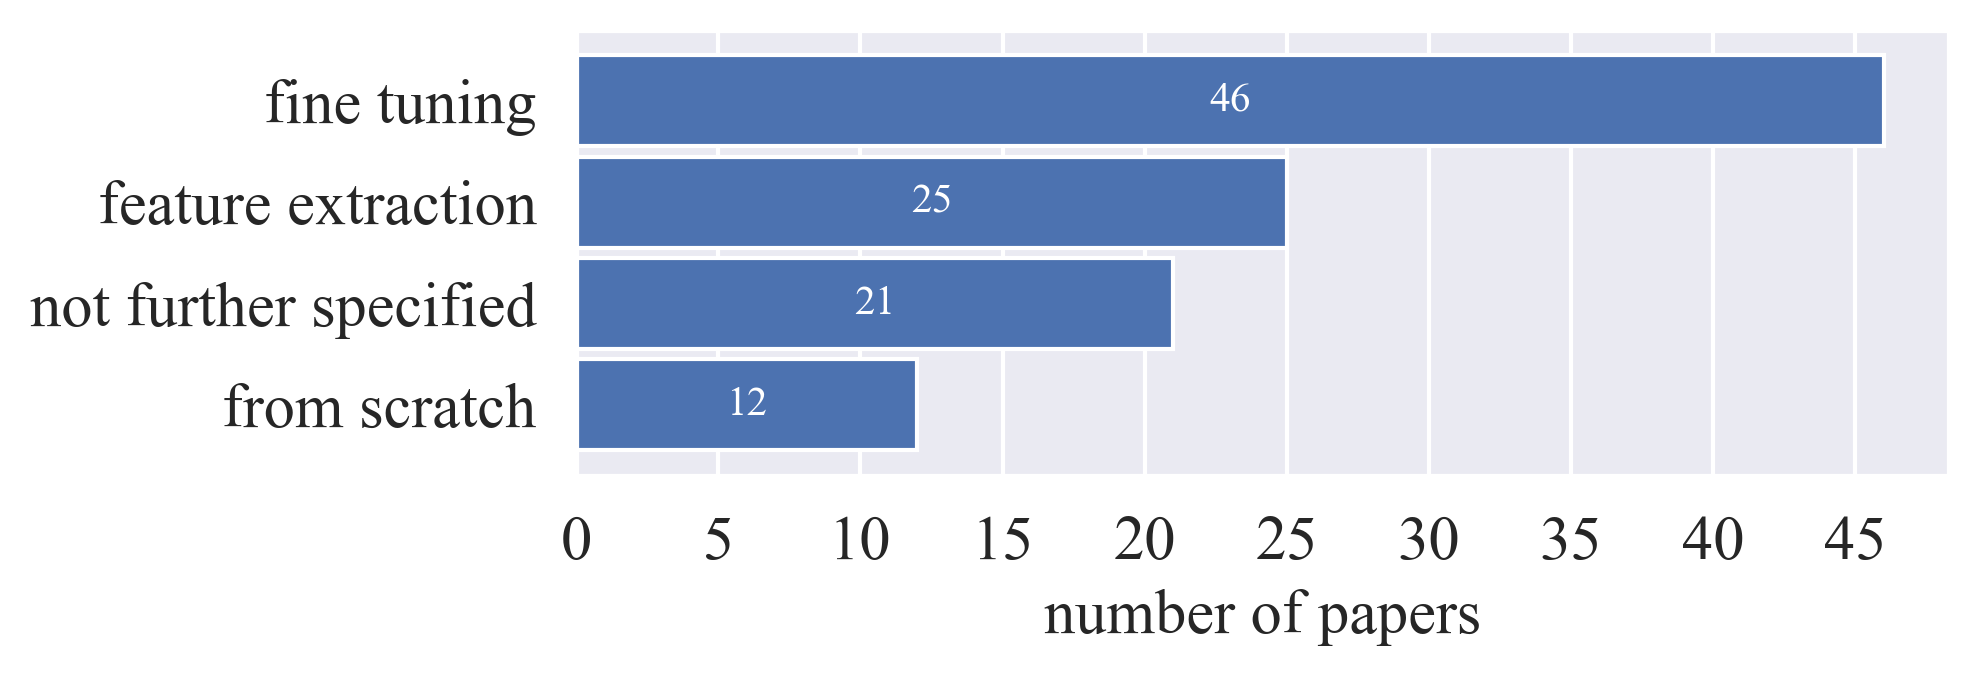

In [53]:
from matplotlib.ticker import MaxNLocator

plotable = tl.sum()
plotable = plotable.sort_values()

title = "transfer learning"
fontsize = 15
figsize=(5.90551, 5.90551/3)

ax = plt.figure().gca()
ax = plotable.plot.barh(rot=0, fontsize=fontsize, figsize=figsize, width=0.9)
ax.set_xlabel('number of papers', fontsize=fontsize)
ax.yaxis.grid(False)
ax.bar_label(ax.containers[0], label_type='center',color='white', fontsize=fontsize-5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig = ax.get_figure()
fig.savefig(title+'.png', bbox_inches='tight')

In [54]:
# how many papers report using more than 1 type of transfer learning
print(len(tl[tl.sum(axis=1) > 1]))
# which
tl[tl.sum(axis=1) > 1]

11


,not further specified,feature extraction,fine tuning,from scratch
Acevedo et al. - 2019 - Recognition of peripheral blood cell im,0,1,1,0
Almezhghwi und Serte - 2020 - Improved Classification of White,0,0,1,1
Alzubaidi et al. - 2020 - Deep Learning Models for Classificati,0,1,1,1
Gräbel et al. - 2020 - Systematic Analysis And Automated Search,0,1,1,1
Harshanand und Sangaiah - 2020 - Comprehensive Analysis of Deep,0,0,1,1
"Huang et al. - 2020 - AML, ALL, and CML classification and diag",0,0,1,1
Kutlu et al. - 2020 - White blood cells detection and classific,1,0,0,1
Loey et al. - 2020 - Deep Transfer Learning in Diagnosing Leuke,0,1,1,0
Ouyang et al. - 2021 - Diagnosing acute promyelocytic leukemia,0,0,1,1
Sahasrabudhe et al. - 2020 - Deep multi-instance learning using,0,1,1,1


### Code sharing

In [55]:
cs = raw.loc[(raw['Code'] == r'code') | (raw['Code'] == r'code\on request') | (raw['Code'] == r'code\in part')]
cs = cs.reset_index().groupby(['Dokumentname', 'Code'])['Code'].aggregate('first').unstack().fillna(1)
cs[r'code'] = pd.to_numeric(cs[r'code'], errors='coerce')
cs[r'code\on request'] = pd.to_numeric(cs[r'code\on request'], errors='coerce')
cs[r'code\in part'] = pd.to_numeric(cs[r'code\in part'], errors='coerce')
cs = cs.fillna(0)
cs = cs.astype(int)
cs = cs.replace(1,2)
cs = cs.replace(0,1)
cs = cs.replace(2,0)
cs.index.name=None
cs.columns.name=None
cs = cs.rename(columns={r'code':'published', r'code\in part': 'published in part', r'code\on request':'available on request'})
cs

,published,published in part,available on request
Alemi Koohbanani et al. - 2020 - NuClick A deep learning framew,1,0,0
Alom et al. - 2018 - Microscopic Blood Cell Classification Usin,1,0,0
Berryman et al. - 2020 - Image-based phenotyping of disaggregat,1,0,0
Brück et al. - 2021 - Machine Learning of Bone Marrow Histopath,1,0,0
Dhieb et al. - 2019 - An Automated Blood Cells Counting and Cla,0,1,0
Elsherif et al. - 2019 - Machine Learning to Quantitate Neutrop,1,0,0
Habibzadeh et al. - 2018 - Automatic white blood cell classific,0,1,0
He et al. - 2020 - CycleGAN With an Improved Loss Function for,1,0,0
Hung et al. - 2020 - Keras R-CNN library for cell detection in,1,0,0
Jiang et al. - 2020 - Geometry-Aware Cell Detection with Deep L,1,0,0


In [56]:
#how many
len(cs)

31

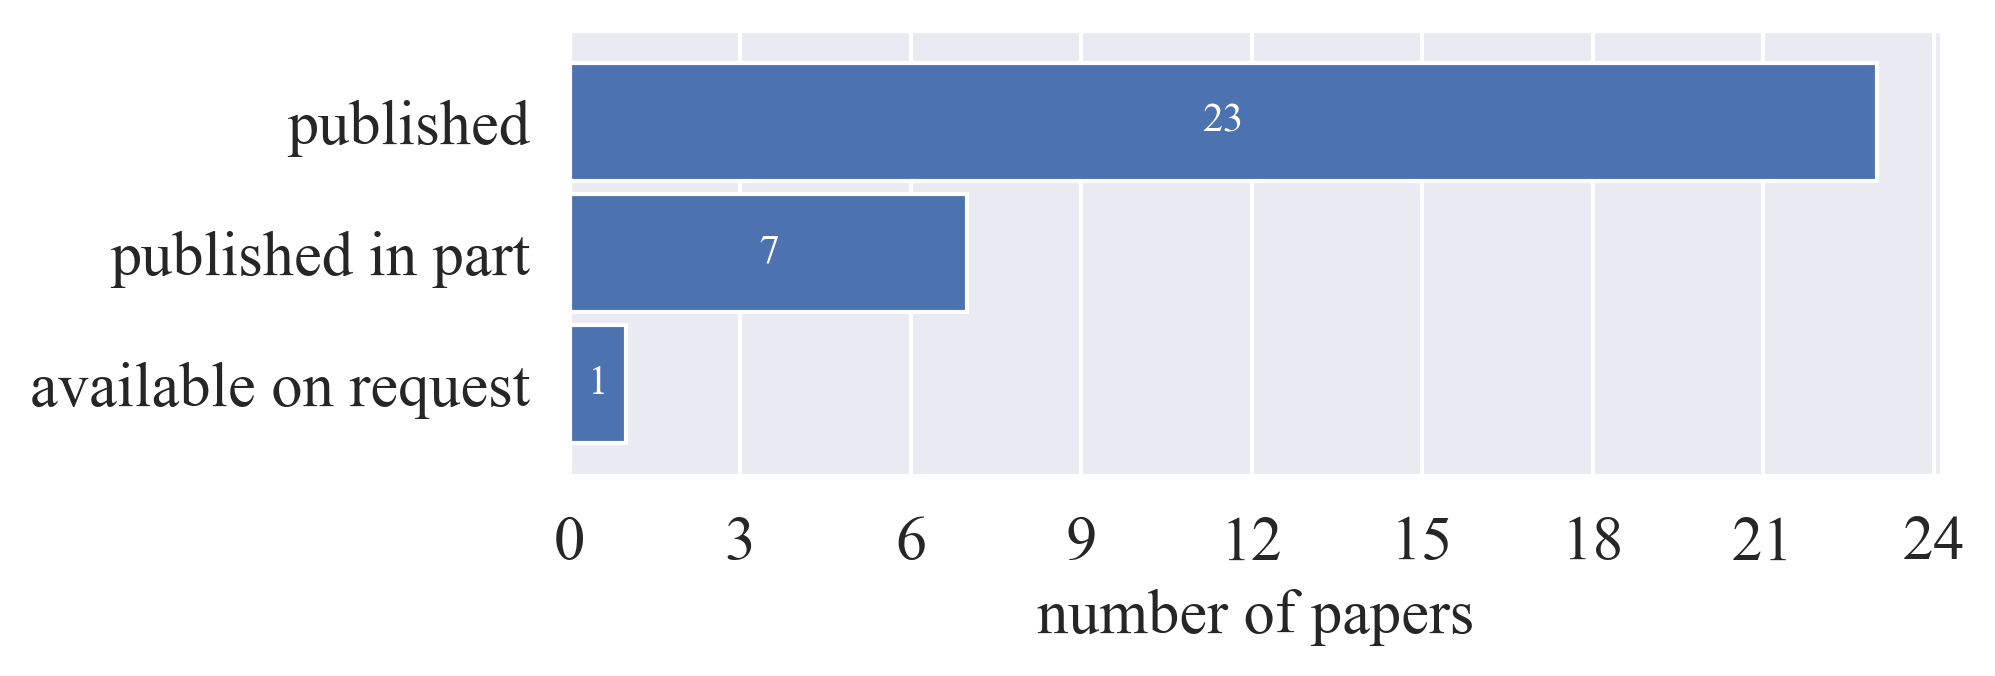

In [57]:
from matplotlib.ticker import MaxNLocator

plotable = cs.sum()
plotable = plotable.sort_values()

title = "code availability"
fontsize = 15
figsize=(5.90551, 5.90551/3)

ax = plt.figure().gca()
ax = plotable.plot.barh(rot=0, fontsize=fontsize, figsize=figsize, width=0.9)
ax.set_xlabel('number of papers', fontsize=fontsize)
ax.yaxis.grid(False)
ax.bar_label(ax.containers[0], label_type='center',color='white', fontsize=fontsize-5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig = ax.get_figure()
fig.savefig(title+'.png', bbox_inches='tight')

### how exactly do they utilize DL-Models to diagnose or aid diagnosing leukemia(s)

In [58]:
# get entries from classification papers
a = raw.loc[(raw.loc[raw['Code'] == r'Task\classification'].index)]
# entries with malignancy
a = a.loc[(a.loc[a['Code'] == r'target scope\target\malignancy'].index)]
# single and multi
a = a.loc[((a['Code'] == r'target scope\single cell') | (a['Code'] == r'target scope\multi cell'))]
malig = a['Code'].value_counts()

In [59]:
a[a.index.duplicated(keep=False)]

,Code,Segment,Kommentar
Dokumentname,,,


In [60]:
# get entries from classification papers
a = raw.loc[(raw.loc[raw['Code'] == r'Task\classification'].index)]
# entries with malignancy
a = a.loc[(a.loc[a['Code'] == r'target scope\target\cell subtypes'].index)]
# single and multi
a = a.loc[((a['Code'] == r'target scope\single cell') | (a['Code'] == r'target scope\multi cell'))]
# duplicate
a = a[~a.index.duplicated(keep='first')]
cell_subtypes = a['Code'].value_counts()

In [61]:
plotable = pd.DataFrame({'malignancy':malig, 'cell types':cell_subtypes})
plotable = plotable.fillna(0)
# sum counts over both vars
plotable['sum'] = plotable.sum(axis=1)
# drop lines (models) if they occur less than twice
#plotable1 = plotable1[plotable1['sum'] > 1]
# sort
plotable = plotable.sort_values('sum')
# drop sum column
plotable = plotable.drop('sum', axis=1)
plotable = plotable.T
columns_titles = [r'target scope\single cell',r'target scope\multi cell']
plotable=plotable.reindex(columns=columns_titles)
plotable

,target scope\single cell,target scope\multi cell
malignancy,27.0,14.0
cell types,75.0,0.0


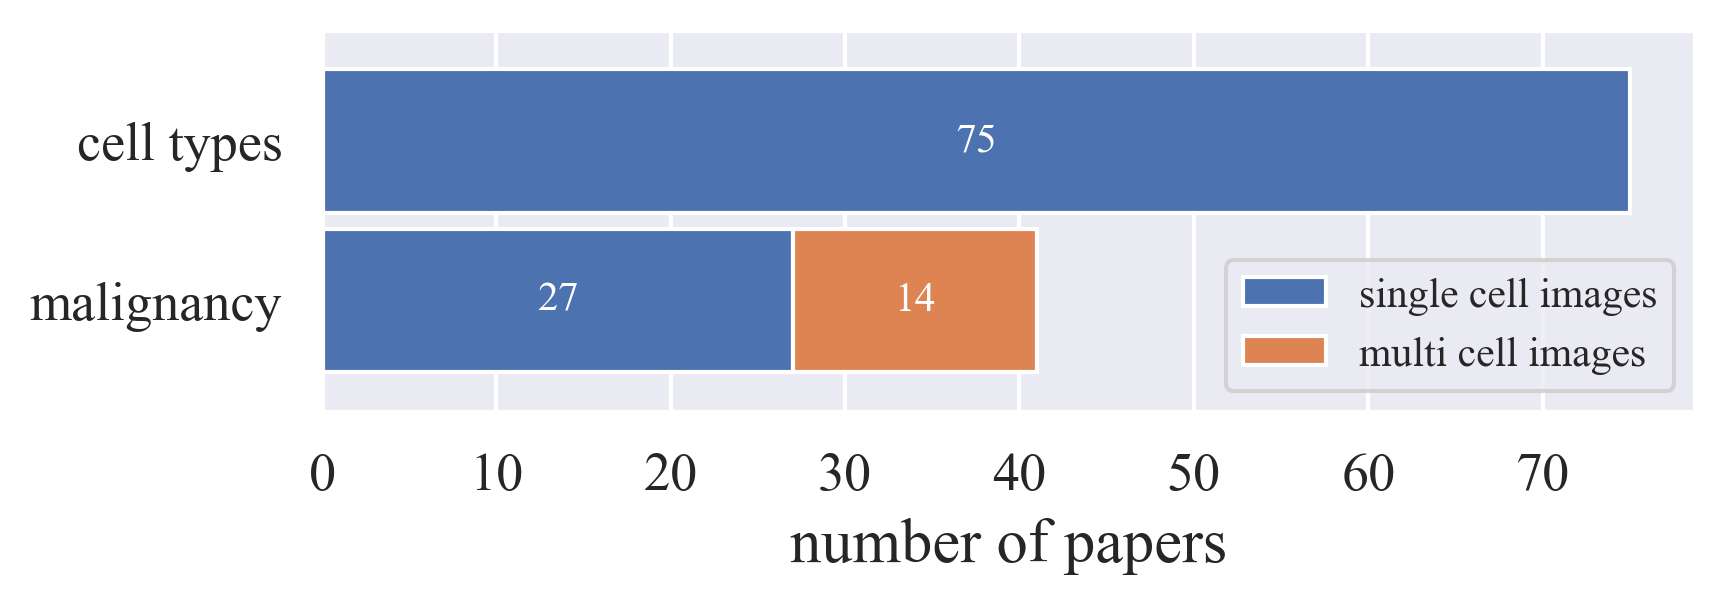

In [62]:
fontsize=15
fontsize_m=13
fontsize_s=10

title = "target_class"
#figsize = (10, 5)
figsize=(5.90551, 5.90551/3.5)

ax = plotable.plot.barh(fontsize=fontsize_m, figsize=figsize, stacked=True, width=0.9)
ax.set_xlabel('number of papers', fontsize=fontsize)
ax.yaxis.grid(False)
ax.bar_label(ax.containers[0],size=fontsize_s, label_type='center',color='white')
ax.bar_label(ax.containers[1], ['' if x==0 else int(x) for x in plotable.iloc[:,1]], size=fontsize_s, label_type='center',color='white')
#ax.bar_label(ax.containers[0], ['' if x==0 else int(x) for x in plotable.iloc[:,1]], size=fontsize_s, label_type='center',color='white')
ax.legend(['single cell images','multi cell images'],fontsize=fontsize_s,loc='lower right')
fig = ax.get_figure()
fig.savefig(title+'.png', bbox_inches='tight')

In [63]:
# get entries from semseg papers
a = raw.loc[(raw.loc[raw['Code'] == r'Task\segmentation\semantic'].index)]
# entries with malignancy
#a = a.loc[(a.loc[a['Code'] == r'target scope\target\cell subtypes'].index)]
# single and multi
a = a.loc[((a['Code'] == r'target scope\target\cell subtypes') | (a['Code'] == r'target scope\target\cell subtype') | (a['Code'] == r'target scope\target\malignancy') | (a['Code'] == r'target scope\target\cells') | (a['Code'] == r'target scope\target\parts of cells'))]
#print(a['Kommentar'].value_counts())
a = a[-a['Kommentar'].isin(['det'])]
non_duplicate = a[~a.index.duplicated(keep=False)]
duplicates = a[a.index.duplicated(keep=False)]
keep = duplicates[duplicates['Kommentar'] == 'seg']
keep2 = duplicates.loc['Zhang et al. - 2020 - Automated Semantic Segmentation of Red Bl']
a = pd.concat([non_duplicate, keep, keep2])
semseg = a['Code'].value_counts()

In [64]:
# get entries from det papers
a = raw.loc[(raw.loc[raw['Code'] == r'Task\detection'].index)]
# entries with malignancy
#a = a.loc[(a.loc[a['Code'] == r'target scope\target\cell subtypes'].index)]
# single and multi
a = a.loc[((a['Code'] == r'target scope\target\cell subtypes') | (a['Code'] == r'target scope\target\cell subtype') | (a['Code'] == r'target scope\target\malignancy') | (a['Code'] == r'target scope\target\cells') | (a['Code'] == r'target scope\target\parts of cells'))]
#print(a['Kommentar'].value_counts())
a = a[-a['Kommentar'].isin(['seg'])]
non_duplicate = a[~a.index.duplicated(keep=False)]
duplicates = a[a.index.duplicated(keep=False)]
keep = duplicates[duplicates['Kommentar'] == 'det']
a = pd.concat([non_duplicate, keep])
det = a['Code'].value_counts()

# get entries from inseg papers
a = raw.loc[(raw.loc[raw['Code'] == r'Task\segmentation\instance'].index)]
# entries with malignancy
#a = a.loc[(a.loc[a['Code'] == r'target scope\target\cell subtypes'].index)]
# single and multi
a = a.loc[((a['Code'] == r'target scope\target\cell subtypes') | (a['Code'] == r'target scope\target\cell subtype') | (a['Code'] == r'target scope\target\malignancy') | (a['Code'] == r'target scope\target\cells') | (a['Code'] == r'target scope\target\parts of cells'))]
non_duplicate = a[~a.index.duplicated(keep=False)]
duplicates = a[a.index.duplicated(keep=False)]
keep = duplicates[duplicates['Kommentar'] == 'seg']
a = pd.concat([non_duplicate, keep])
inseg = a['Code'].value_counts()

# get entries from semseg papers
a = raw.loc[(raw.loc[raw['Code'] == r'Task\segmentation\semantic'].index)]
# entries with malignancy
#a = a.loc[(a.loc[a['Code'] == r'target scope\target\cell subtypes'].index)]
# single and multi
a = a.loc[((a['Code'] == r'target scope\target\cell subtypes') | (a['Code'] == r'target scope\target\cell subtype') | (a['Code'] == r'target scope\target\malignancy') | (a['Code'] == r'target scope\target\cells') | (a['Code'] == r'target scope\target\parts of cells'))]
#print(a['Kommentar'].value_counts())
a = a[-a['Kommentar'].isin(['det'])]
non_duplicate = a[~a.index.duplicated(keep=False)]
duplicates = a[a.index.duplicated(keep=False)]
keep = duplicates[duplicates['Kommentar'] == 'seg']
keep2 = duplicates.loc['Zhang et al. - 2020 - Automated Semantic Segmentation of Red Bl']
a = pd.concat([non_duplicate, keep, keep2])
semseg = a['Code'].value_counts()

In [65]:
plotable = pd.DataFrame({'detection':det, 'instance segmentation':inseg, 'semantic segmentation':semseg})
plotable = plotable.fillna(0)
# sum counts over both vars
plotable['sum'] = plotable.sum(axis=1)
# drop lines (models) if they occur less than twice
#plotable1 = plotable1[plotable1['sum'] > 1]
# sort
plotable = plotable.sort_values('sum')
# drop sum column
plotable = plotable.drop('sum', axis=1)
index_titles = ['malignancy','parts of cells','cells in general','single cell type','multiple cell types']
plotable.index = index_titles
plotable

,detection,instance segmentation,semantic segmentation
malignancy,0.0,1,1
parts of cells,1.0,1,4
cells in general,5.0,1,2
single cell type,7.0,2,11
multiple cell types,16.0,4,6


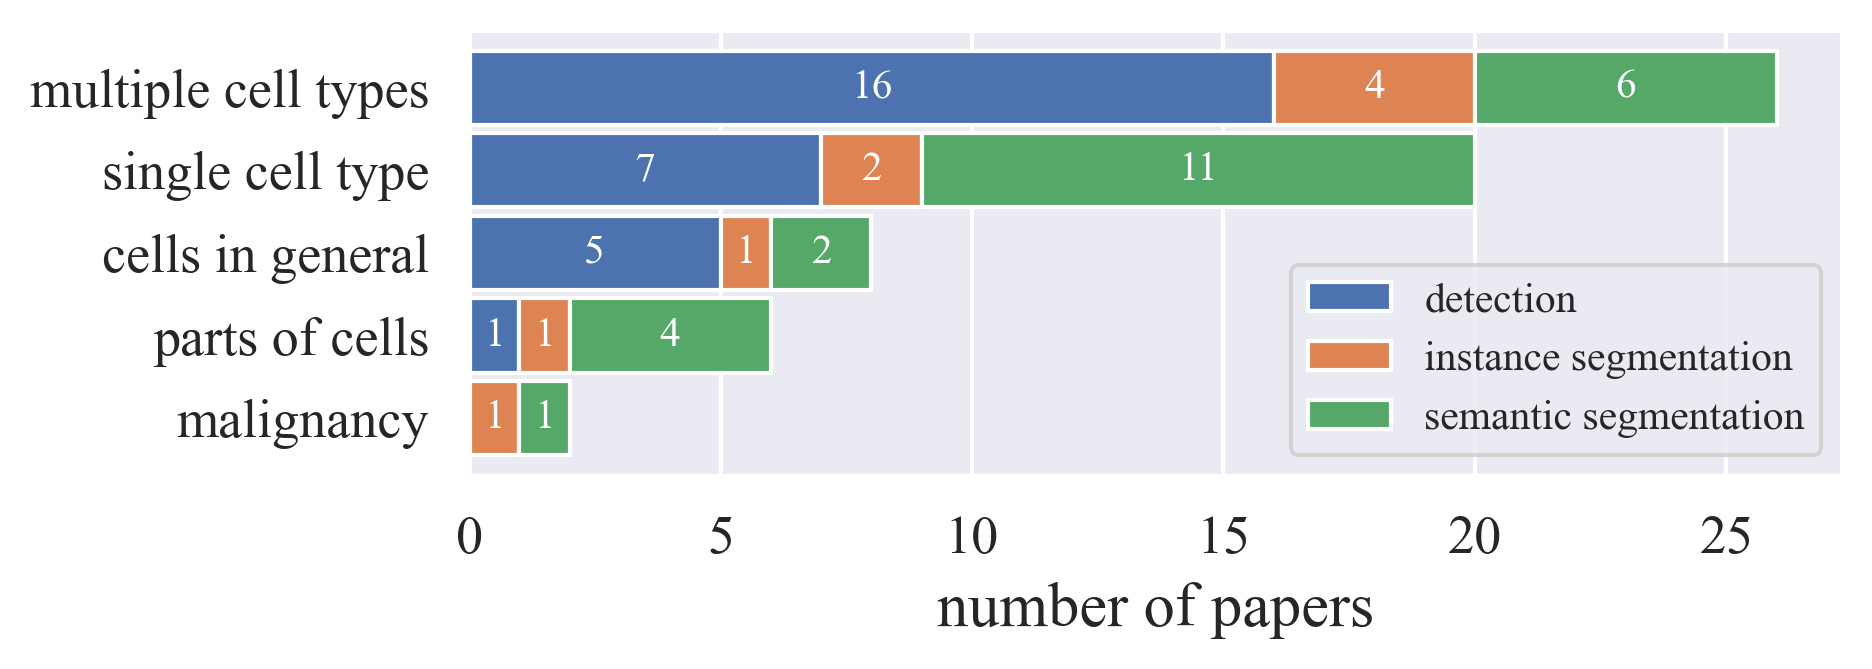

In [66]:
fontsize=15
fontsize_m=13
fontsize_s=10

title = "target_det_seg"
#figsize = (10, 5)
figsize=(5.90551, 5.90551/3)

ax = plotable.plot.barh(fontsize=fontsize_m, figsize=figsize, stacked=True, width=0.9)
ax.set_xlabel('number of papers', fontsize=fontsize)
ax.yaxis.grid(False)
ax.bar_label(ax.containers[0], ['' if x==0 else int(x) for x in plotable.iloc[:,0]], size=fontsize_s, label_type='center',color='white')
ax.bar_label(ax.containers[1], ['' if x==0 else int(x) for x in plotable.iloc[:,1]], size=fontsize_s, label_type='center',color='white')
ax.bar_label(ax.containers[2], ['' if x==0 else int(x) for x in plotable.iloc[:,2]], size=fontsize_s, label_type='center',color='white')
ax.legend(['detection','instance segmentation','semantic segmentation'],fontsize=fontsize_s,loc='lower right')
fig = ax.get_figure()
fig.savefig(title+'.png', bbox_inches='tight')

### Augmentation

In [67]:
aug = raw.loc[raw['Code'] == 'transformations'].copy()

In [68]:
# how many papers report on transformations at all?
len(aug.index.unique())

110

In [69]:
# how many per paper on average
np.mean(aug.index.value_counts().values)

3.7545454545454544

In [70]:
# standard deviation
np.std(aug.index.value_counts().values)

2.580297247275499

In [71]:
# which transformations are most used?
aug_count = aug['Segment'].value_counts()
# only plot transforms reported more than once
plotable = aug_count[aug_count > 1]

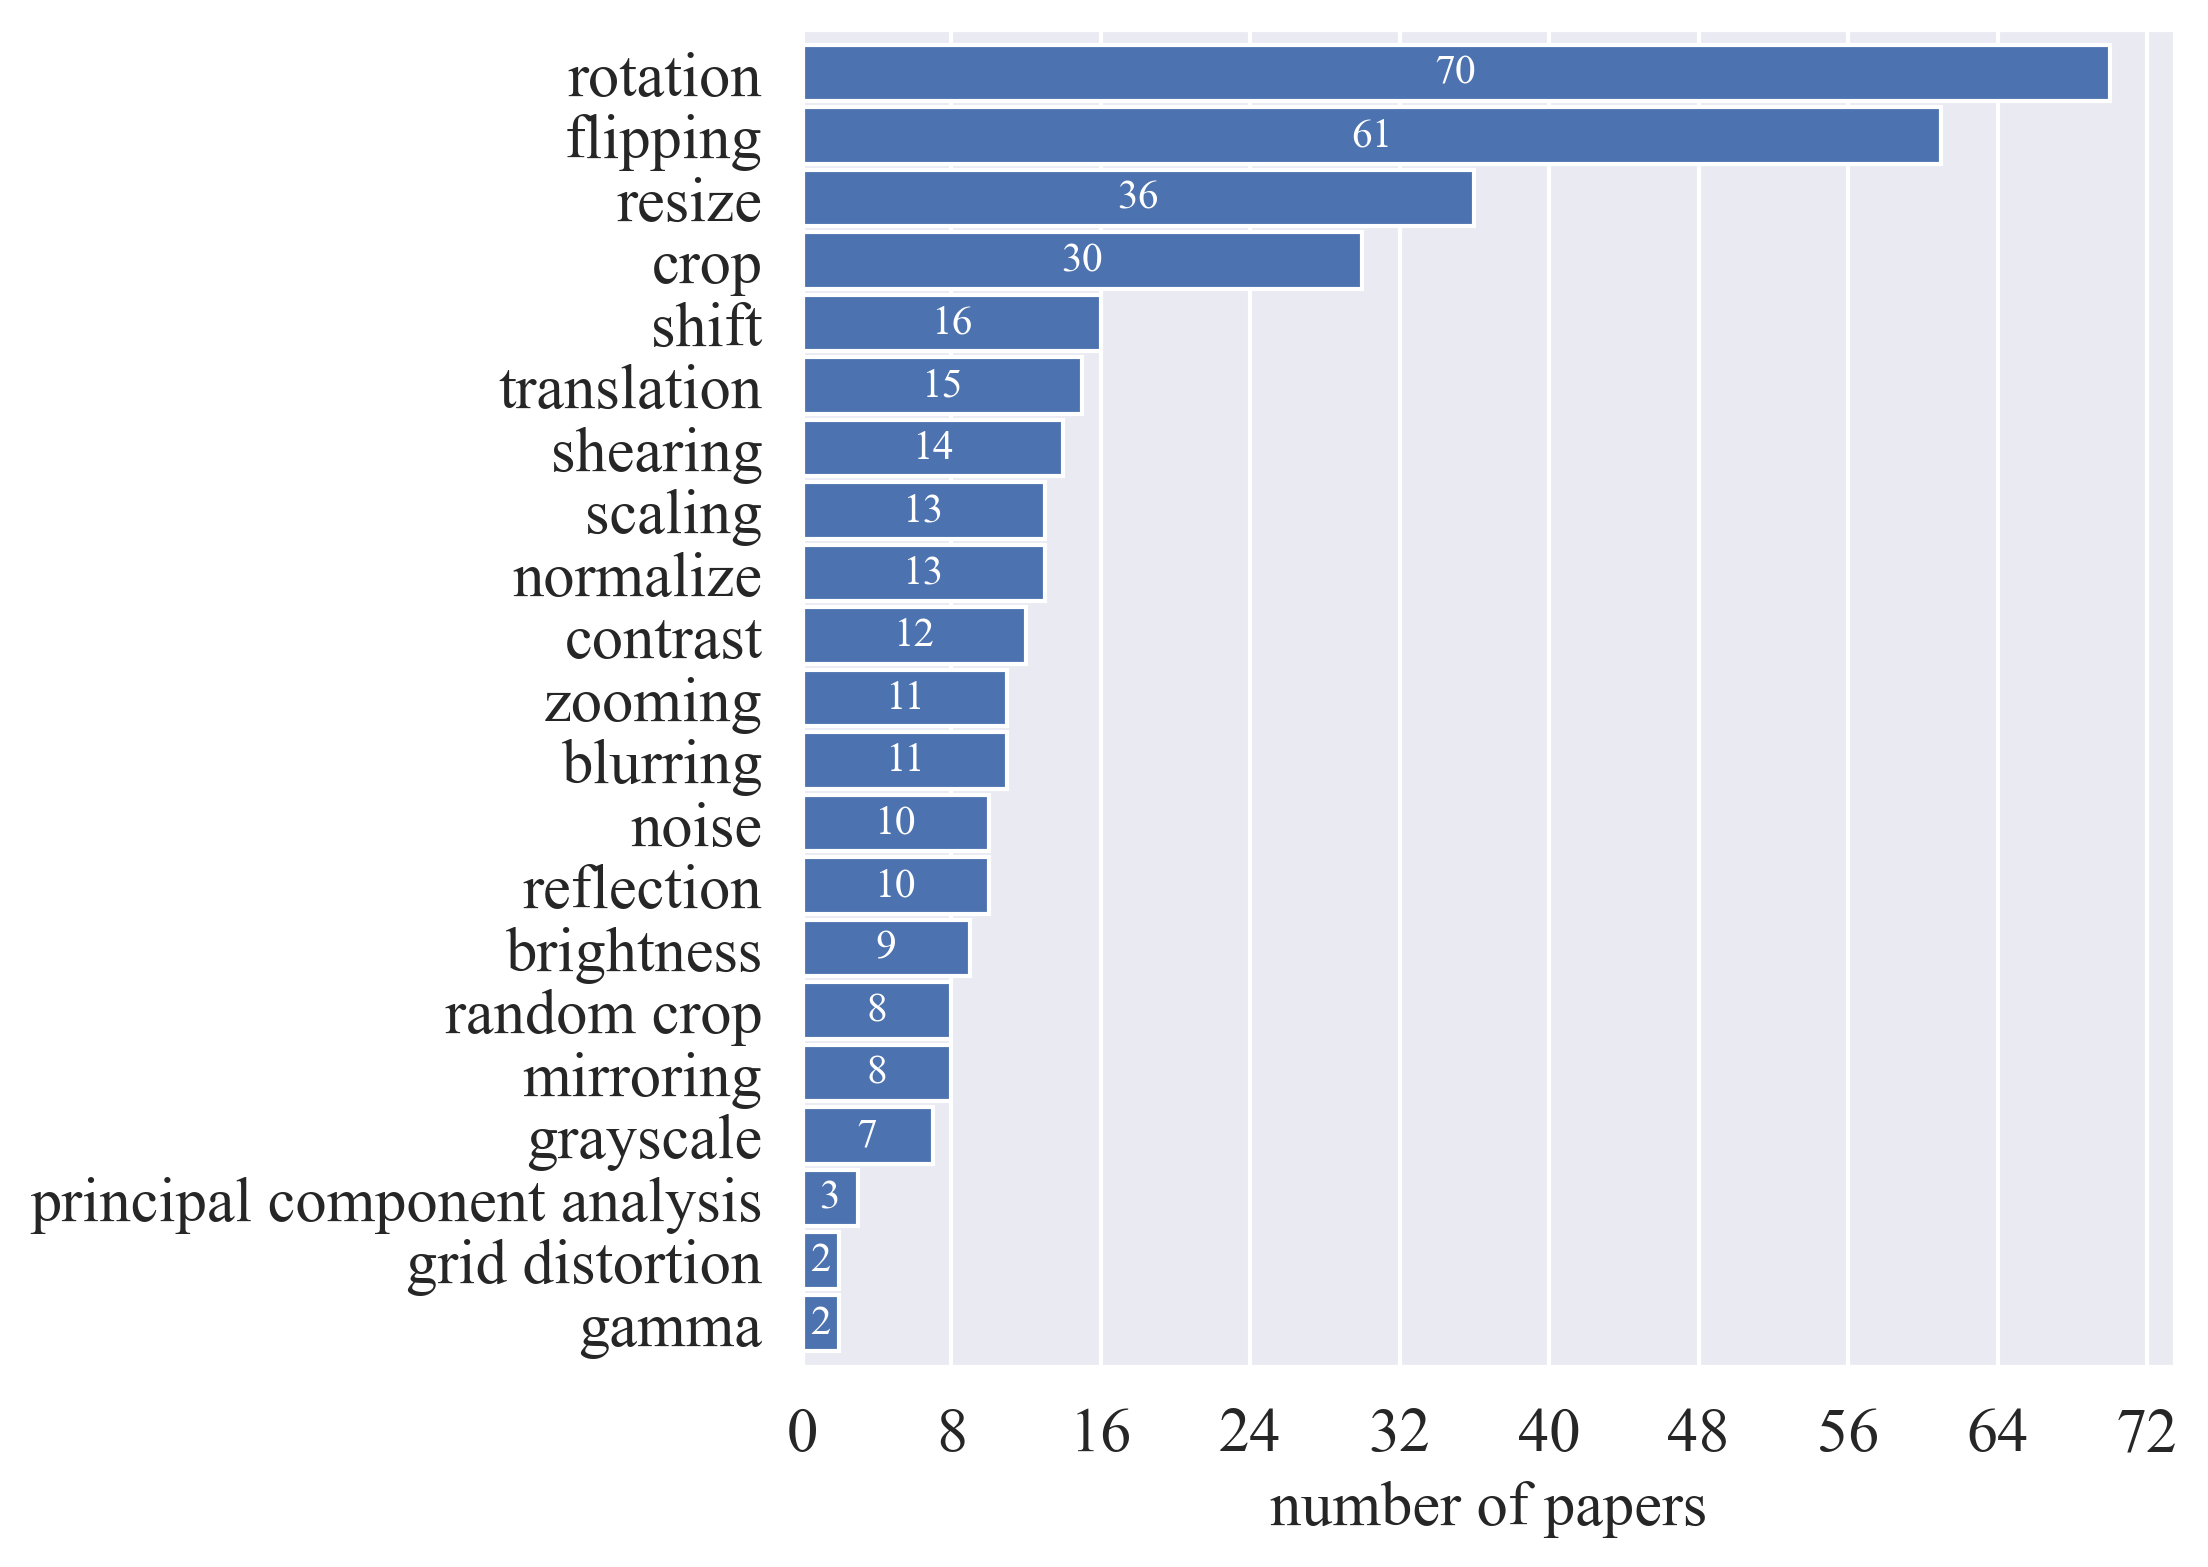

In [72]:
plotable = plotable.sort_values()

title = "Data Augmentation"
fontsize = 15
figsize=(5.90551, 5.90551)

ax = plt.figure().gca()
ax = plotable.plot.barh(rot=0, fontsize=fontsize, figsize=figsize, width=0.9)
ax.set_xlabel('number of papers', fontsize=fontsize)
ax.yaxis.grid(False)
ax.bar_label(ax.containers[0], label_type='center',color='white', fontsize=fontsize-5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig = ax.get_figure()
fig.savefig(title+'.png', bbox_inches='tight')

### DATA

In [166]:
datasets = raw.loc[raw['Code'] == r'Data\name'].copy()
# overwrite Segment entries with Kommentar entries when they or not nan
datasets['Segment'] = datasets.Kommentar.fillna(datasets.Segment)
raw.loc[raw['Code'] == r'Data\name', 'Segment'] = datasets['Segment']

In [167]:
df_counts.columns.map(lambda x: x.startswith('Data'))

Index([False, False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False],
      dtype='object', name='Code')

In [168]:
# Data\details\size dataset
# Data\details\patients
# Data\details\size images
# Data\details\classes
# Data\details\type of smear\peripheral blood     Data\details\type of smear\bone marrow
# Data\details\class balance
# Data\details\staining
# Data\details\microscope/camera
# Data\available      Data\available\partly         Data\available\on request         Data\available\requires registration

In [169]:
#
double_filtered = raw.loc[raw[(raw['Code']==r'Data\name') & (raw['Segment']=='Dhruv Parthasarathy')].index]
#double_filtered[double_filtered['Code'] == r'Data\details\classes']['Segment']

In [170]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
double_filtered[double_filtered['Code'] == r'Data\details\type of smear\peripheral blood']

,Code,Segment,Kommentar
Dokumentname,,,
Naz et al. - 2019 - Robust Discrimination of Leukocytes Protube,Data\details\type of smear\peripheral blood,NaN,NaN
Wang et al. - 2018 - Classification of White Blood Cells with P,Data\details\type of smear\peripheral blood,NaN,NaN
Habibzadeh et al. - 2018 - Automatic white blood cell classific,Data\details\type of smear\peripheral blood,NaN,NaN
Alzubaidi et al. - 2020 - Deep Learning Models for Classificati,Data\details\type of smear\peripheral blood,NaN,NaN
Alom et al. - 2018 - Microscopic Blood Cell Classification Usin,Data\details\type of smear\peripheral blood,NaN,NaN


## multi-dataset 

In [171]:
# overwrite elaborate comments with ints
cleaning = raw.loc[raw['Code'] == r'Data\multiple datasets', 'Kommentar']

cleaning['Alam und Islam - 2019 - Machine learning approach of automatic '] = 2
cleaning['Alemi Koohbanani et al. - 2020 - NuClick A deep learning framew'] = 3
cleaning['Cao et al. - 2020 - FPB Improving Multi-Scale Feature Represent'] = 1
cleaning['Jiang et al. - 2020 - Geometry-Aware Cell Detection with Deep L'] = 1
cleaning['Lin et al. - 2018 - Leukocyte recognition with convolutional ne'] = 3
cleaning['Shahin et al. - 2019 - White blood cells identification system '] = 4
cleaning['Tsykunov et al. - 2020 - Application of Deep Learning Methods f'] = 2
cleaning['Ye et al. - 2019 - Dual attention based fine-grained leukocyte '] = 3
cleaning['Razzak und Naz - 2017 - Microscopic Blood Smear Segmentation an'] = 3
cleaning['Xie et al. - 2018 - Microscopy cell counting and detection with'] = 2
cleaning['Zhao et al. - 2017 - Automatic detection and classification of '] = 4

raw.loc[raw['Code'] == r'Data\multiple datasets', 'Kommentar'] = cleaning

In [172]:
# tagged with multi dataset tag
multivar = raw.loc[raw['Code'] == r'Data\multiple datasets', 'Kommentar'].sort_index()

In [173]:
# actually contains multiple datasets
data_count = df_counts[(df_counts[r'Data\name'].notna()) & (df_counts[r'Data\name'] > 1)][r'Data\name'].astype('int')

In [174]:
# put combined and separate into one df
plotable1 = pd.DataFrame({'separate':data_count[df_counts[r'Data\multiple datasets\combined'].isna()].value_counts(), 'combined':data_count[df_counts[r'Data\multiple datasets\combined'].notna()].value_counts()})
plotable1 = plotable1.sort_index(ascending=False)

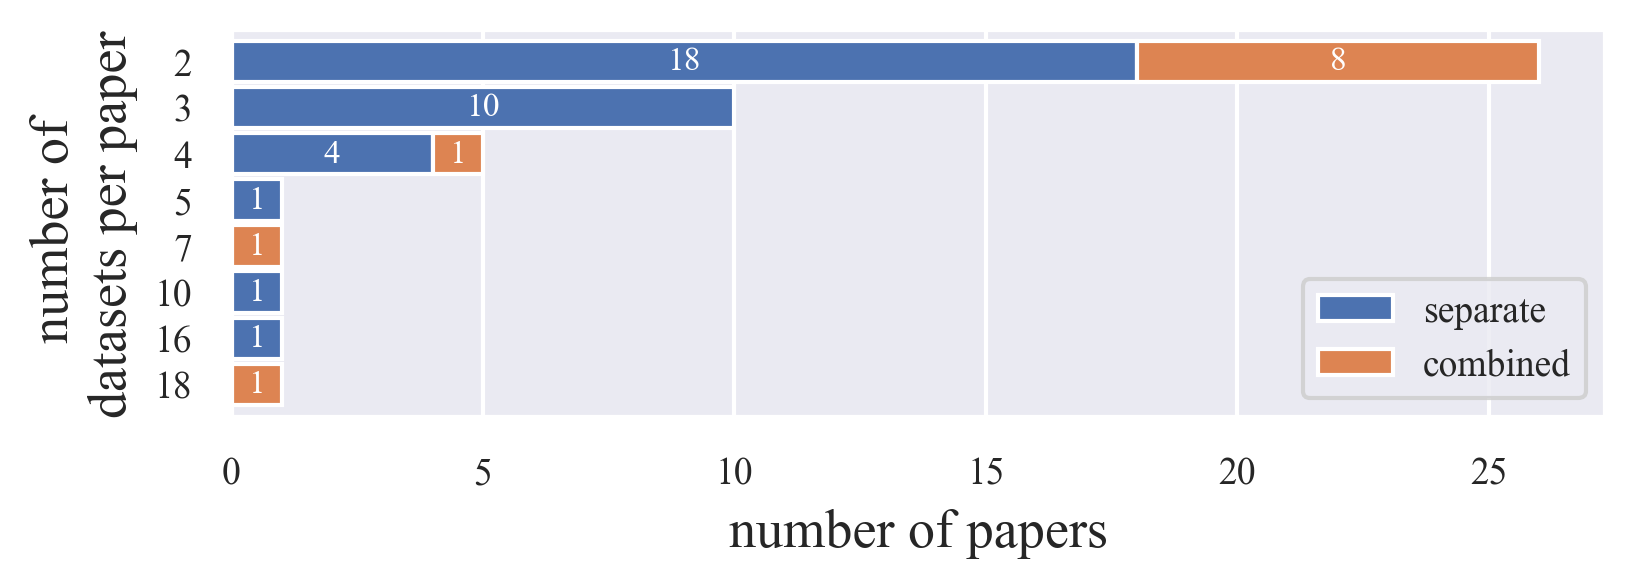

In [175]:
fontsize=13
fontsize_m=9
fontsize_s=8

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
fig = plt.figure(figsize=(5.90551, 5.90551/1.5))
gs = GridSpec(nrows=2, ncols=2,wspace=0.4,hspace=0.3)
ax0 = fig.add_subplot(gs[0,:])
plotable1.plot.barh(fontsize=fontsize_m,stacked=True,ax=ax0,legend=False, width=0.9)
ax0.set_xlabel('number of papers', fontsize=fontsize)
ax0.set_ylabel('number of \ndatasets per paper', fontsize=fontsize)
ax0.yaxis.grid(False)
#ax0.set_title('dataset utilization', fontsize=fontsize)
ax0.bar_label(ax0.containers[0], ['' if math.isnan(x) else int(x) for x in plotable1.iloc[:,0]],size=fontsize_s, label_type='center',color='white')
ax0.bar_label(ax0.containers[1], ['' if math.isnan(x) else int(x) for x in plotable1.iloc[:,1]], size=fontsize_s, label_type='center',color='white')
ax0.legend(fontsize=fontsize_m,loc='lower right')

fig.savefig('datasets_combined_vs_single.png', bbox_inches='tight')

In [176]:
# concat (hand curated) single and multi use datasets and get low level stats (reported vs not reported for each var)
all_datasets = pd.read_excel('Datasets.xlsx', sheet_name=['single_use_datasets','multi_use_datasets'])

In [177]:
all_datasets['single_use_datasets'].drop(['Paper Name','num. Datasets','combined','dataset'], axis=1, inplace=True)
all_datasets['multi_use_datasets'].drop(['Comment','slides','occurences','links','comment','dataset'], axis=1, inplace=True)
all_datasets = pd.concat([all_datasets['single_use_datasets'],all_datasets['multi_use_datasets']])

In [178]:
all_datasets['bone marrow'].replace('peripheral', np.nan, inplace=True)

In [179]:
# how many unique datasets in all papers?
len(all_datasets)

140

In [180]:
# which report both single and multi cell number of patches
all_datasets[all_datasets['single cell patches'].notna() & all_datasets['multi cell patches'].notna()]
#how many
len(all_datasets[all_datasets['single cell patches'].notna() & all_datasets['multi cell patches'].notna()])

29

In [181]:
# how many don't report either?
len(all_datasets[all_datasets['single cell patches'].isna() & all_datasets['multi cell patches'].isna()])

13

In [182]:
plotable = all_datasets.notna().sum()
#reverse order
plotable = plotable.iloc[::-1]

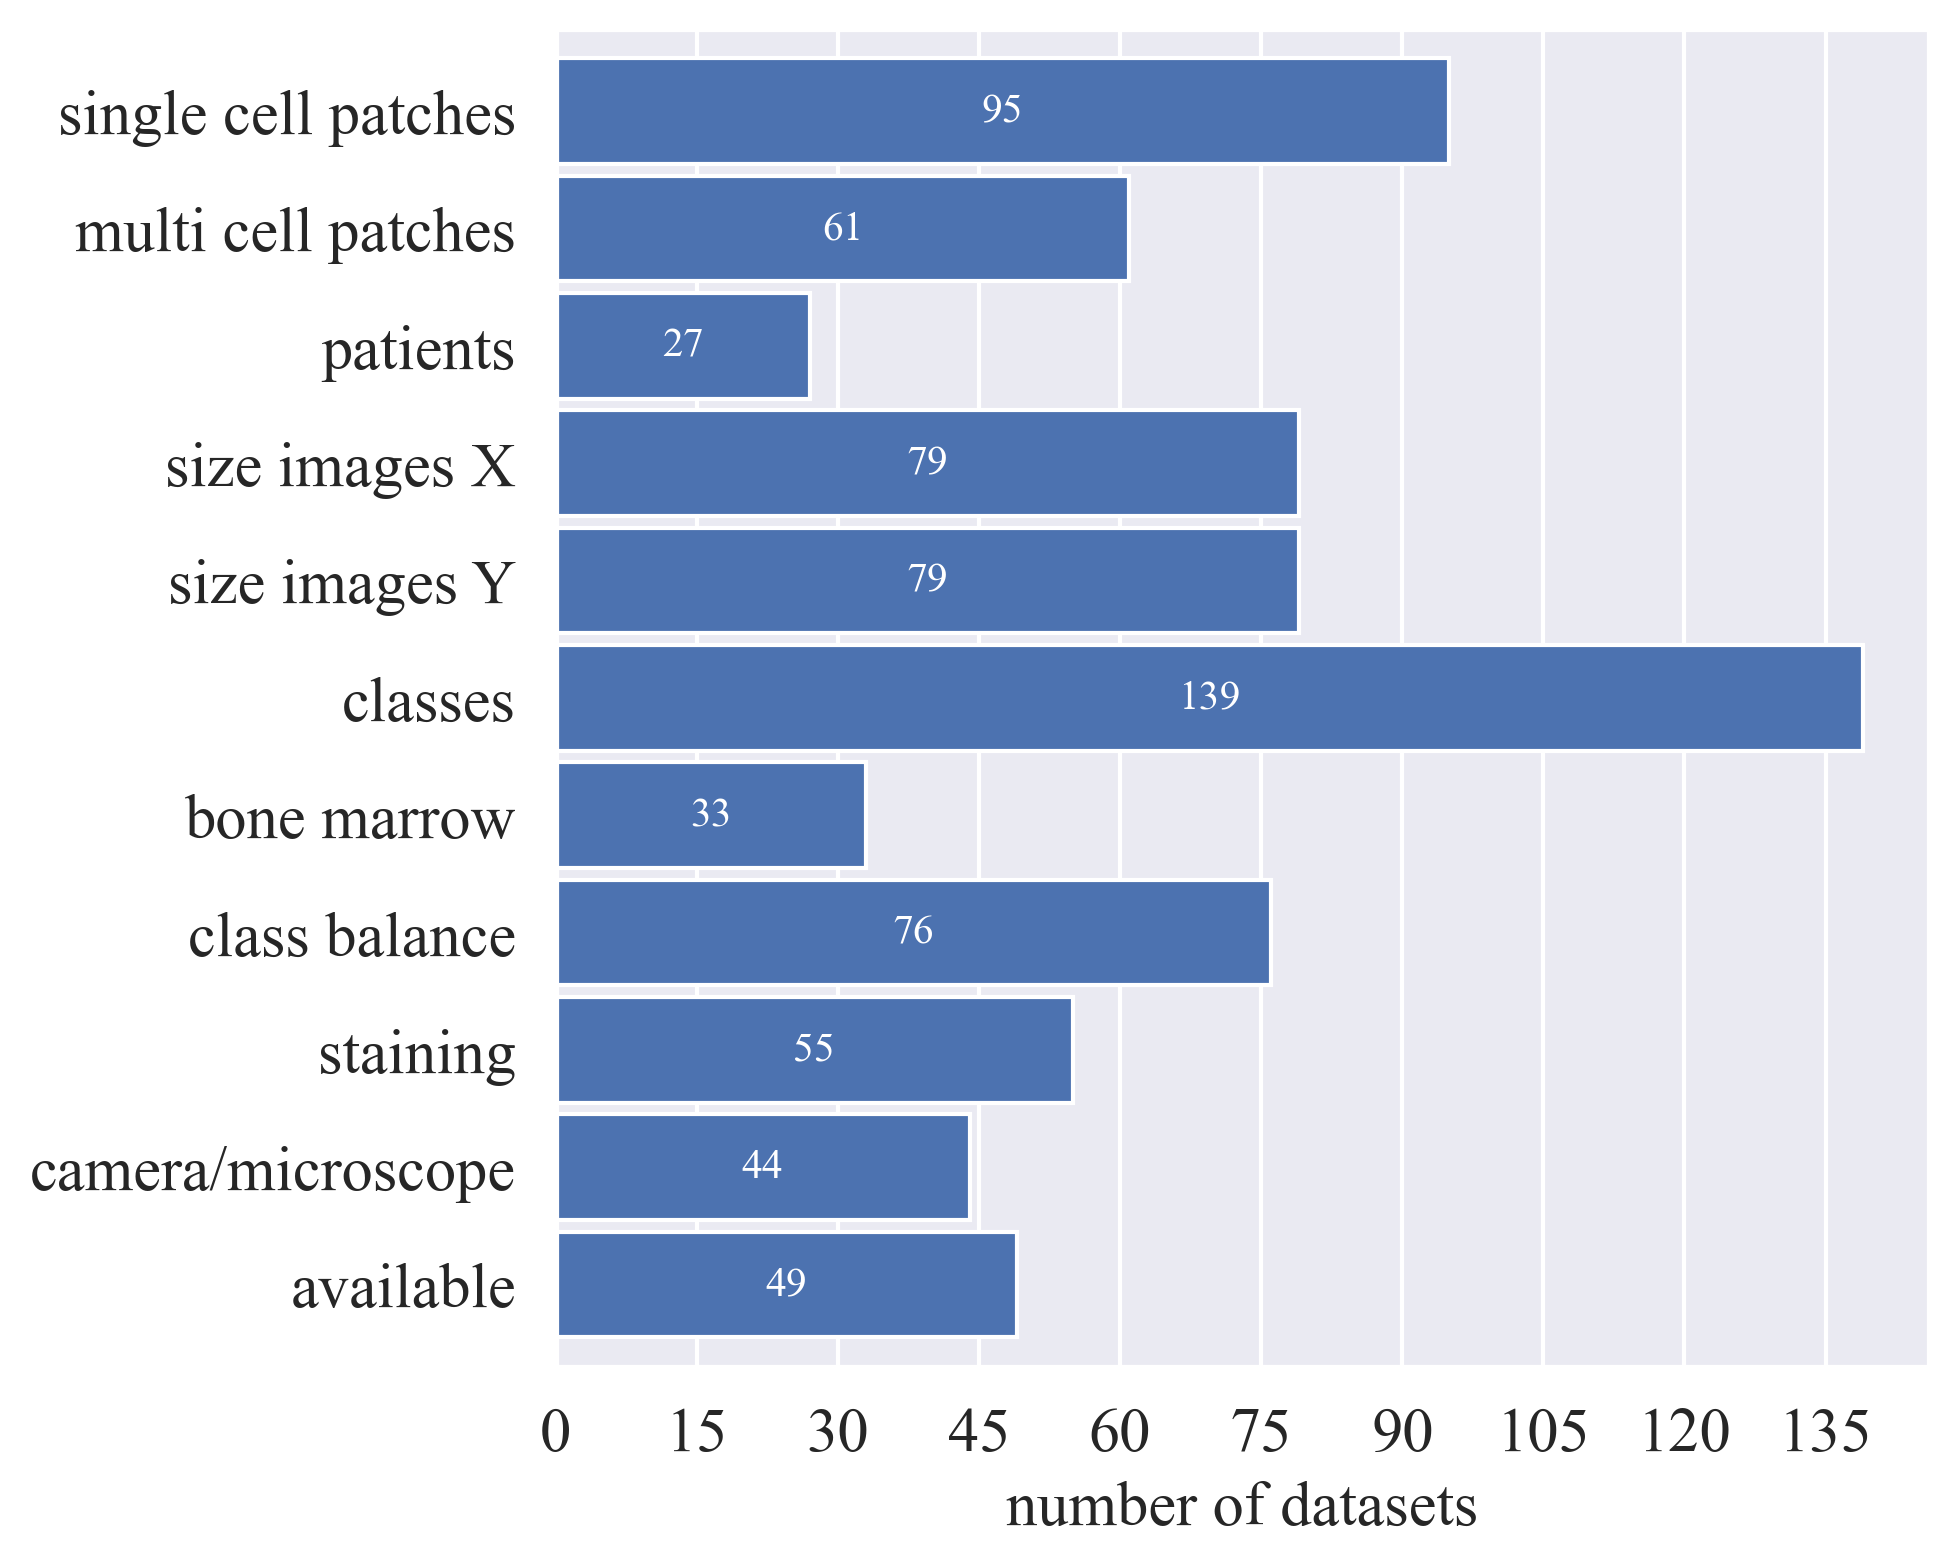

In [183]:
title = "low_level_stats_datasets"
fontsize = 15
figsize=(5.90551, 5.90551)

ax = plt.figure().gca()
ax = plotable.plot.barh(rot=0, fontsize=fontsize, figsize=figsize, width=0.9)
ax.set_xlabel('number of datasets', fontsize=fontsize)
ax.yaxis.grid(False)
ax.bar_label(ax.containers[0], label_type='center',color='white', fontsize=fontsize-5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig = ax.get_figure()
fig.savefig(title+'.png', bbox_inches='tight')

In [184]:
all_datasets['single cell patches'].replace('40000-x',40000, inplace=True)
all_datasets['single cell patches'].replace('739-x',739, inplace=True)
all_datasets['size images X'].replace('350-2592',1471, inplace=True)
all_datasets['size images X'].replace('32, 128',32, inplace=True)
all_datasets['size images X'].replace('300, 1000',300, inplace=True)
all_datasets['size images X'].replace('300, 360',300, inplace=True)
all_datasets['size images X'].replace('198-609',400, inplace=True)
all_datasets['size images Y'].replace('236-1944',1090, inplace=True)
all_datasets['size images Y'].replace('32, 128',32, inplace=True)
all_datasets['size images Y'].replace('300, 1000',300, inplace=True)
all_datasets['size images Y'].replace('300, 363',300, inplace=True)
all_datasets['size images Y'].replace('189-643',400, inplace=True)

In [185]:
plotable1 = all_datasets['single cell patches']
plotable2 = all_datasets['multi cell patches']
plotable3 = all_datasets['patients']
plotable4 = all_datasets['size images X']
plotable5 = all_datasets['size images Y']

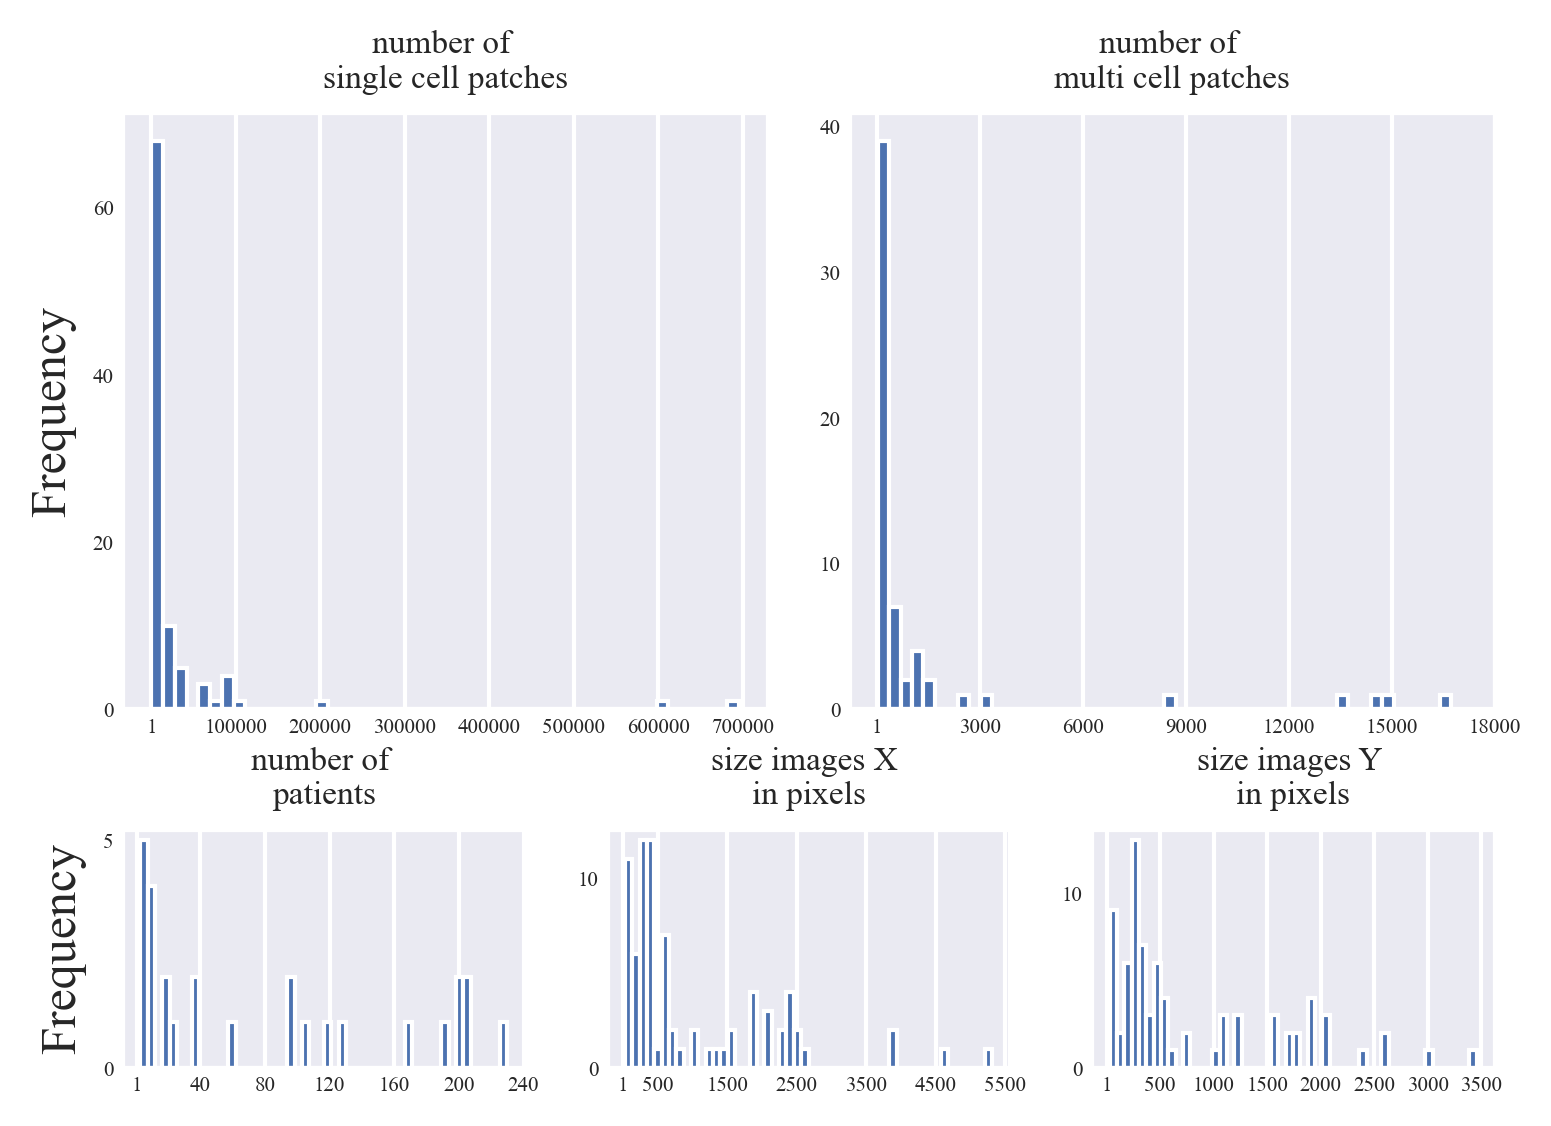

In [186]:
fontsize=8
fontsize_m=5
fontsize_s=5

bins=50

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
fig = plt.figure(figsize=(5.90551, 5.90551/1.4))
gs = GridSpec(nrows=3, ncols=6,wspace=0.5,hspace=0.5)
ax0 = fig.add_subplot(gs[:2,:3])
#ax0.set_xlim([0, int(plotable1.max())+1])
plotable1.plot.hist(bins=bins, fontsize=fontsize_m,ax=ax0,legend=False)
ax0.tick_params(axis='both', which='major', pad=-4)
ax0.xaxis.set_ticks([1,100000,200000,300000,400000,500000,600000,700000])
ax0.yaxis.grid(False)
ax0.set_title('number of \nsingle cell patches', fontsize=fontsize)
#ax0.bar_label(ax0.containers[0],size=fontsize_s, label_type='center',color='white')
#ax0.bar_label(ax0.containers[1], ['' if math.isnan(x) else int(x) for x in plotable1.iloc[:,1]], size=fontsize_s, label_type='center',color='white')
ax1 = fig.add_subplot(gs[:2,3:])
plotable2.plot.hist(bins=bins, fontsize=fontsize_m,ax=ax1,legend=False)
ax1.set_ylabel('')
ax1.tick_params(axis='both', which='major', pad=-4)
ax1.xaxis.set_ticks([1,3000,6000,9000,12000,15000,18000])
ax1.yaxis.grid(False)
ax1.set_title('number of \nmulti cell patches', fontsize=fontsize)
#ax1.bar_label(ax1.containers[0],size=fontsize_s, label_type='center',color='white')
#ax1.bar_label(ax1.containers[1], ['' if math.isnan(x) else int(x) for x in plotable2.iloc[:,1]],size=fontsize_s, label_type='center',color='white')
ax2 = fig.add_subplot(gs[2,:2])
plotable3.plot.hist(bins=bins, fontsize=fontsize_m,ax=ax2,legend=False)
ax2.tick_params(axis='both', which='major', pad=-4)
ax2.xaxis.set_ticks([1,40,80,120,160,200,240])
ax2.yaxis.grid(False)
ax2.set_title('number of \npatients', fontsize=fontsize)
#ax2.bar_label(ax2.containers[0],size=fontsize_s, label_type='center',color='white')
#ax2.bar_label(ax2.containers[1], ['' if math.isnan(x) else int(x) for x in plotable3.iloc[:,1]],size=fontsize_s, label_type='center',color='white')
ax3 = fig.add_subplot(gs[2,2:4])
plotable4.plot.hist(bins=bins, fontsize=fontsize_m,ax=ax3)
ax3.set_ylabel('')
ax3.tick_params(axis='both', which='major', pad=-4)
ax3.xaxis.set_ticks([1,500,1500,2500,3500,4500,5500])
ax3.yaxis.grid(False)
ax3.set_title('size images X \nin pixels', fontsize=fontsize)
#ax3.bar_label(ax3.containers[0],size=fontsize_s, label_type='center',color='white')
#ax3.bar_label(ax3.containers[1], ['' if math.isnan(x) else int(x) for x in plotable4.iloc[:,1]],size=fontsize_s, label_type='center',color='white')
#ax3.legend(fontsize=fontsize_m,loc='lower right')
ax4 = fig.add_subplot(gs[2,4:])
plotable5.plot.hist(bins=bins, fontsize=fontsize_m,ax=ax4)
ax4.set_ylabel('')
ax4.tick_params(axis='both', which='major', pad=-4)
start, end = ax4.get_xlim()
ax4.xaxis.set_ticks([1,500,1000,1500,2000,2500,3000,3500])
ax4.yaxis.grid(False)
ax4.set_title('size images Y \nin pixels', fontsize=fontsize)
#ax4.bar_label(ax3.containers[0],size=fontsize_s, label_type='center',color='white')
#ax4.bar_label(ax3.containers[1], ['' if math.isnan(x) else int(x) for x in plotable4.iloc[:,1]],size=fontsize_s, label_type='center',color='white')
#ax4.legend(fontsize=fontsize_m,loc='lower right')

fig.savefig('descriptive_stats_hist.png', bbox_inches='tight')

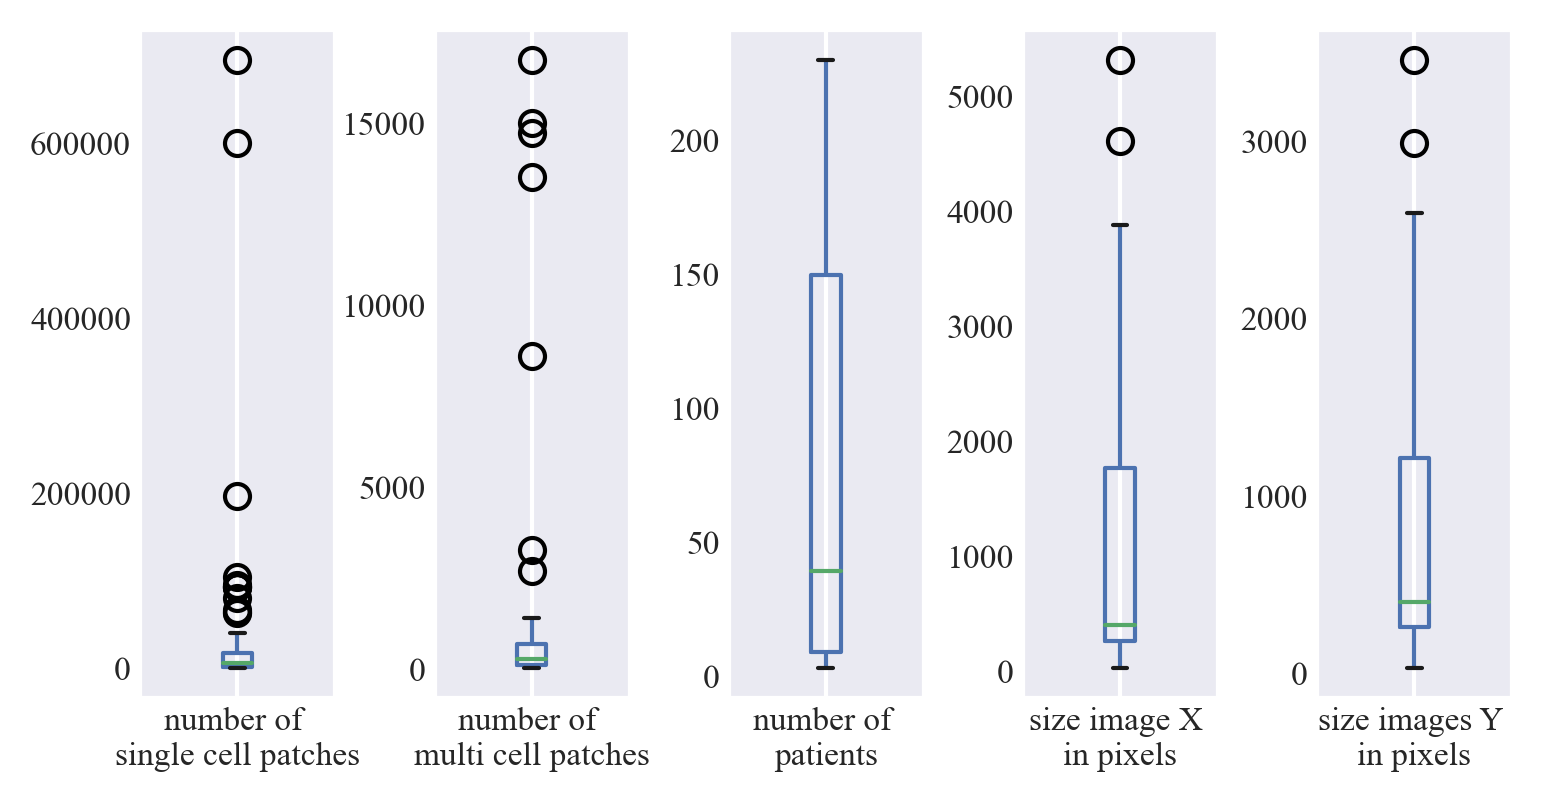

In [188]:
fontsize=8
fontsize_m=8
fontsize_s=5

bins=50

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
fig = plt.figure(figsize=(5.90551, 5.90551/2))
gs = GridSpec(nrows=1, ncols=5,wspace=0.5,hspace=0.5)

ax0 = fig.add_subplot(gs[0,0])
#ax0.set_xlim([0, int(plotable1.max())+1])
plotable1.name = 'number of \nsingle cell patches'
plotable1.plot.box(fontsize=fontsize_m,ax=ax0,legend=False)
ax0.tick_params(axis='both', which='major', pad=-4)
ax0.yaxis.grid(False)
#ax0.set_title('number of \nsingle cell patches', fontsize=fontsize)
#ax0.bar_label(ax0.containers[0],size=fontsize_s, label_type='center',color='white')
#ax0.bar_label(ax0.containers[1], ['' if math.isnan(x) else int(x) for x in plotable1.iloc[:,1]], size=fontsize_s, label_type='center',color='white')

ax1 = fig.add_subplot(gs[0,1])
plotable2.name = 'number of \nmulti cell patches'
plotable2.plot.box(fontsize=fontsize_m,ax=ax1,legend=False)
ax1.set_ylabel('')
ax1.tick_params(axis='both', which='major', pad=-4)
ax1.yaxis.grid(False)
#ax1.set_title('number of \nmulti cell patches', fontsize=fontsize)
#ax1.bar_label(ax1.containers[0],size=fontsize_s, label_type='center',color='white')
#ax1.bar_label(ax1.containers[1], ['' if math.isnan(x) else int(x) for x in plotable2.iloc[:,1]],size=fontsize_s, label_type='center',color='white')

ax2 = fig.add_subplot(gs[0,2])
plotable3.name = 'number of \npatients'
plotable3.plot.box(fontsize=fontsize_m,ax=ax2,legend=False)
ax2.tick_params(axis='both', which='major', pad=-4)
ax2.yaxis.grid(False)
#ax2.set_title('number of \npatients', fontsize=fontsize)
#ax2.bar_label(ax2.containers[0],size=fontsize_s, label_type='center',color='white')
#ax2.bar_label(ax2.containers[1], ['' if math.isnan(x) else int(x) for x in plotable3.iloc[:,1]],size=fontsize_s, label_type='center',color='white')

ax3 = fig.add_subplot(gs[0,3])
plotable4.name = 'size image X \nin pixels'
plotable4.plot.box(fontsize=fontsize_m,ax=ax3)
ax3.set_ylabel('')
ax3.tick_params(axis='both', which='major', pad=-4)
ax3.yaxis.grid(False)
#ax3.set_title('size images X \nin pixels', fontsize=fontsize)
#ax3.bar_label(ax3.containers[0],size=fontsize_s, label_type='center',color='white')
#ax3.bar_label(ax3.containers[1], ['' if math.isnan(x) else int(x) for x in plotable4.iloc[:,1]],size=fontsize_s, label_type='center',color='white')
#ax3.legend(fontsize=fontsize_m,loc='lower right')

ax4 = fig.add_subplot(gs[0,4])
plotable5.name = 'size images Y \nin pixels'
plotable5.plot.box(fontsize=fontsize_m,ax=ax4)
ax4.set_ylabel('')
ax4.tick_params(axis='both', which='major', pad=-4)
ax4.yaxis.grid(False)
#ax4.set_title('size images Y \nin pixels', fontsize=fontsize)
#ax4.bar_label(ax3.containers[0],size=fontsize_s, label_type='center',color='white')
#ax4.bar_label(ax3.containers[1], ['' if math.isnan(x) else int(x) for x in plotable4.iloc[:,1]],size=fontsize_s, label_type='center',color='white')
#ax4.legend(fontsize=fontsize_m,loc='lower right')

fig.savefig('descriptive_stats_box.png', bbox_inches='tight')

In [194]:
plotable2.max()

16728.0

In [97]:
# get IQR*1.5 for first two variables cause they are hard to see in plot
series_of_interes = plotable2

print('IQR:')
IQR = series_of_interes.quantile(0.75)-series_of_interes.quantile(0.25)
print(IQR)
print('lower')
print(series_of_interes.quantile(0.25)-1.5*IQR)
print('upper')
print(series_of_interes.quantile(0.75)+1.5*IQR)

IQR:
574.0
lower
-765.0
upper
1531.0


### Hardware

In [101]:
# how many report on hardware used
len(df_counts[df_counts['hardware'].notna()].index.unique())

75

In [102]:
plotable = df_counts[[r'hardware\CPU',r'hardware\RAM',r'hardware\GPU']].count()
rename_dict = {r'hardware\CPU':'CPU',
              r'hardware\RAM':'RAM',
              r'hardware\GPU':'GPU'}
plotable = plotable.rename(rename_dict)
plotable = plotable.sort_values()

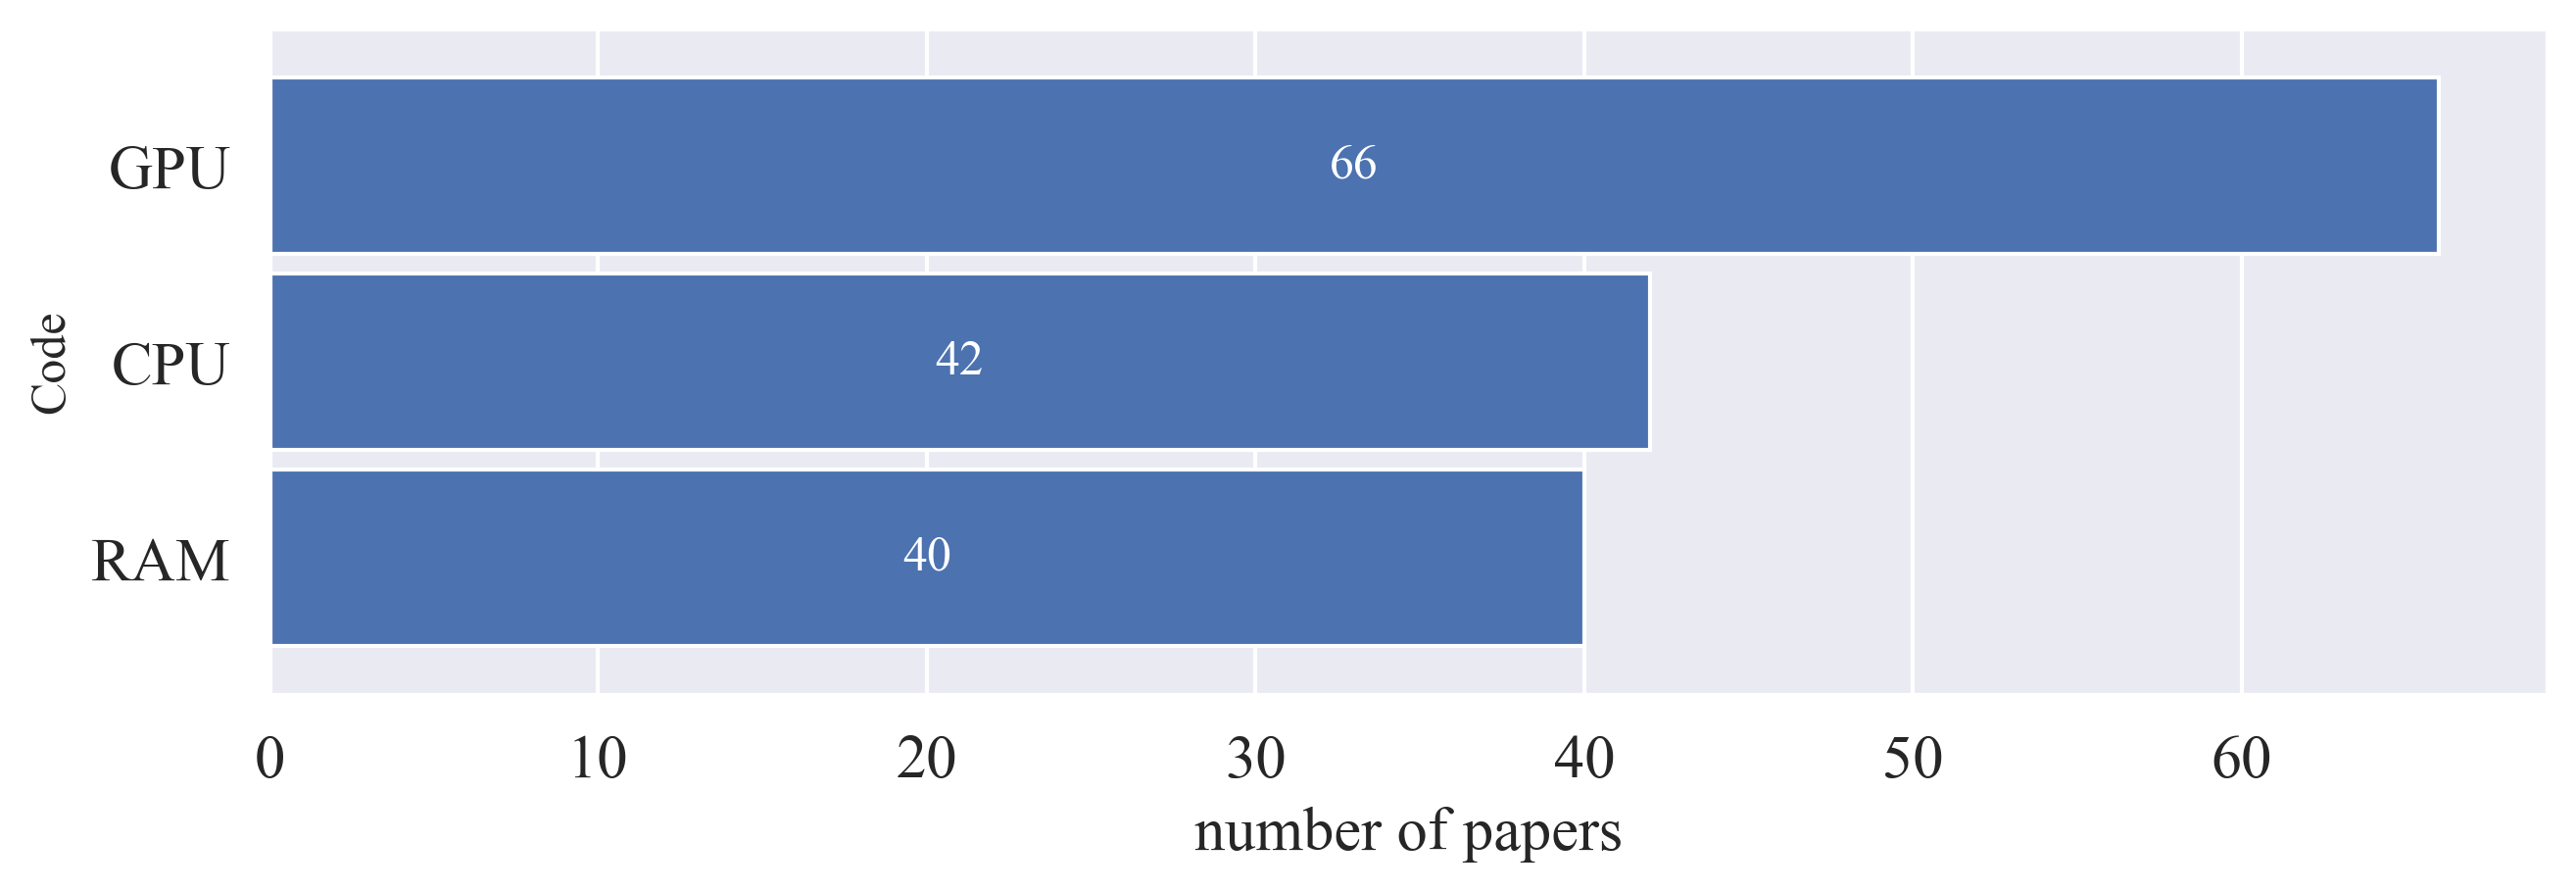

In [103]:
title = "Hardware"
fontsize = 15
figsize = (10, 3)

ax = plotable.plot.barh(rot=0, fontsize=fontsize, figsize=figsize, width=0.9)
ax.set_xlabel('number of papers', fontsize=fontsize)
ax.yaxis.grid(False)
ax.bar_label(ax.containers[0], label_type='center',color='white')
fig = ax.get_figure()
fig.savefig(title+'.png', bbox_inches='tight')

In [162]:
# plot reported RAM usage for papers
ram = raw[raw['Code'] == r'hardware\RAM']
plotable = ram['Segment'].str.replace('\D+', '')
plotable['Bani-Hani et al. - 2018 - Classification of Leucocytes Using Co'] = 32
plotable['Berryman et al. - 2020 - Image-based phenotyping of disaggregat'] = 64
plotable['Jiang et al. - 2021 - Improved detection performance in blood c'] = 192
plotable['Jin et al. - 2020 - Developing and Preliminary Validating an Au'] = 64
plotable['Kasamsumran et al. - 2020 - Applying Faster R-CNN for Hematocyt'] = 32
plotable['Pansombut et al. - 2019 - Convolutional Neural Networks for Rec'] = 12
plotable['Parab und Mehendale - 2021 - Red Blood Cell Classification Usin'] = 24
plotable = plotable.astype(int)
plotable = plotable.value_counts().sort_index()

<ipython-input-162-1855693a3ff8>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  plotable = ram['Segment'].str.replace('\D+', '')


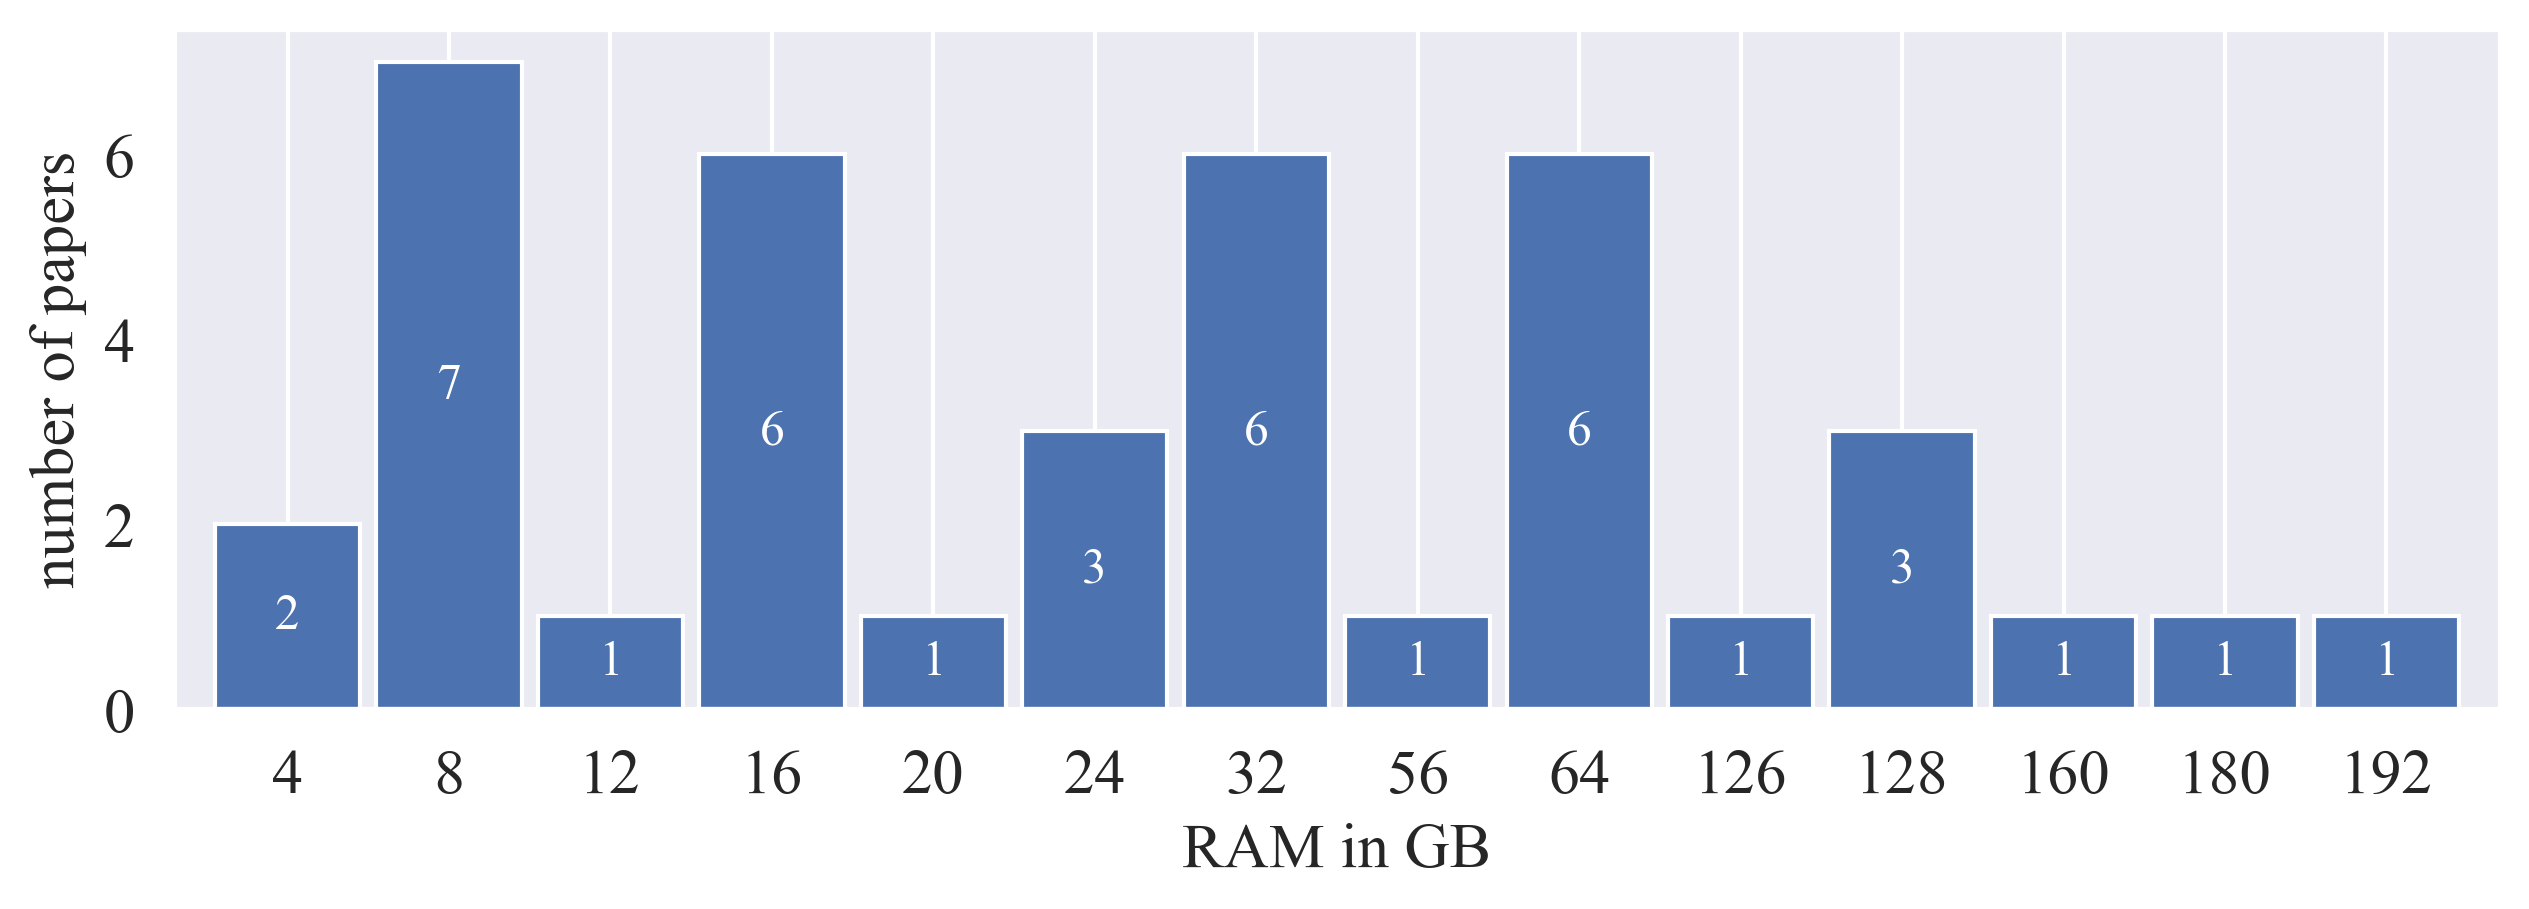

In [165]:
title = "RAM usage"
fontsize = 15
figsize = (10, 3)

ax = plotable.plot.bar(rot=0, fontsize=fontsize, figsize=figsize, width=0.9)
ax.set_ylabel('number of papers', fontsize=fontsize)
ax.set_xlabel('RAM in GB', fontsize=fontsize)
ax.yaxis.grid(False)
ax.bar_label(ax.containers[0], label_type='center',color='white')
fig = ax.get_figure()
fig.savefig(title+'.png', bbox_inches='tight')